# Notebook to looks at the effects of the CRISPR guides on the disease relevant gene(s) in a specific celltype

- effects of CRISPR guides targeting CREs of LRRK2 in microglia
    - add in additional monogenic and high-risk PD genes for clustering purposes; and cell marker genes
    - PD monogenic and risk gene list based on following references
        - (https://pubmed.ncbi.nlm.nih.gov/30448284/)
        - (https://pubmed.ncbi.nlm.nih.gov/27090875/)

In [1]:
!date

Fri Feb 18 13:19:16 EST 2022


#### import libraries and set notebook variables

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import statsmodels.stats.multitest as smm

%matplotlib inline

In [3]:
# naming
cohort = 'lrrk2_crispr'
gene_oi = 'LRRK2'

# directories
wrk_dir = '/labshare/LNG_Single_cell_data/Cookson_scCRISPRi_iMicroglia/modified_pipe_from_10x'

# in files
in_file = f'{wrk_dir}/{cohort}.scanpy.h5ad'

# out files
results_file = f'{wrk_dir}/{cohort}.crispr_dcas.{gene_oi}.h5ad'
guides_results_file = f'{wrk_dir}/{cohort}.crispr_dcas.{gene_oi}.guides.results.csv'
targets_results_file = f'{wrk_dir}/{cohort}.crispr_dcas.{gene_oi}.targets.results.csv'
gene_data_file = f'{wrk_dir}/{cohort}.crispr_dcas.{gene_oi}.data.csv'
figS5_data_file = f'{wrk_dir}/{cohort}.crispr_dcas.fig_s5.data.csv'
umap_data_file = f'{wrk_dir}/{cohort}.crispr_dcas.umap.data.csv'

# variables
debug = True
# add some other monogenic and high risk disease genes
cell_markers = ['TGFBR1', 'DOCK8', 'CD74', 'CSF1R', 'P2RY12', 'ITGAM', 'CX3CR1', 
                'CCL4', 'CCL3', 'CTSS', 'RGS10', 'AIF1', 'CST7', 'CSF1', 'LPL', 
                'APOE', 'SPP1', 'CD74', 'ITGAX']
fig_s5_markers = ['CSF1R', 'IL1B', 'FCGR2A', 'P2RY12', 'ITGAM', 'CX3CR1', 
                  'TGFB1', 'TNF', 'CD68', 'CXCL8', 'CD86', 'CD74', 'TMEM119']
dx_genes = ['SNCA', 'LRRK2', 'PARK2', 'PINK1', 'PARK7', 'ATP13A2', 'PLA2G6', 
            'FBXO7', 'DNAJC6', 'MAPT', 'GBA', 'VPS35', 'UCHL1', 'GIGYF2', 
            'HTRA2', 'EIF4G1', 'DNAJC16']
# combines lists with sets to make unique elements in list
genes_oi = list(set([gene_oi]) | set(dx_genes) | set(cell_markers) | set(fig_s5_markers))
ordered_targets = ['sgNT', 'sgPeak38433', 'sgPeak38437', 'sgPeak38439', 
                   'sgrs7294619', 'sgPeak38440', 'sgPeak38441', 'mixed']

In [4]:
print(genes_oi)

['TNF', 'FBXO7', 'HTRA2', 'TGFB1', 'LPL', 'GIGYF2', 'SPP1', 'ITGAX', 'TMEM119', 'TGFBR1', 'AIF1', 'DNAJC16', 'DNAJC6', 'SNCA', 'FCGR2A', 'P2RY12', 'RGS10', 'CCL4', 'PARK7', 'ATP13A2', 'LRRK2', 'UCHL1', 'CTSS', 'APOE', 'CD86', 'PARK2', 'PINK1', 'PLA2G6', 'VPS35', 'DOCK8', 'CST7', 'CD74', 'CXCL8', 'CX3CR1', 'IL1B', 'CSF1R', 'CD68', 'EIF4G1', 'ITGAM', 'CCL3', 'MAPT', 'GBA', 'CSF1']


In [5]:
print(len(genes_oi))

43


#### utility functions

In [6]:
def convert_ad_to_df(data: ad.AnnData, obs_features: list, verbose: bool=False) -> pd.DataFrame:
    data_df = data.to_df()
    annots = data.obs[obs_features].copy()
    this_df = None
    if data_df.index.equals(annots.index):
        this_df = pd.concat([data_df, annots], axis='columns')
        if verbose:
            print(f'anndata to pandas df complete: {this_df.shape}')
            print(this_df.shape)
            display(this_df.head())
    return this_df

def glm_model(formula: str, df: pd.DataFrame, verbose: bool=False, 
                      use_tweedie: bool=True):
    if use_tweedie:
        model = smf.glm(formula=formula, data=df, 
                        family=sm.families.Tweedie(link=None, var_power=1.6, 
                                                   eql=True))
    else:
        model = smf.glm(formula=formula, data=df)
    result = model.fit()
    if verbose:
        print(result.summary())
    return result

#plot by target
def plot_ordered_targets(gene: str, df: pd.DataFrame, feature_order: list, 
                         drop_zeros: bool=False):
    if drop_zeros:
        this_df = df.loc[df[gene] > 0]
    else:
        this_df = df
    plt.figure(figsize=(9,9))
    sns.boxenplot(x='target',y=gene, scale='exponential', data=this_df,
                  k_depth='trustworthy', order=feature_order)
    thisplt = sns.stripplot(x='target', y=gene, data=this_df, alpha=0.5,
                           jitter=True, color='darkgrey', order=feature_order)
    loc, labels = plt.xticks()
    thisplt.set_xticklabels(labels, rotation=60)
    plt.title(f'{gene} scaled expression by target', fontsize='large') 
    plt.xlabel('Target')
    plt.ylabel(f'{gene} scaled expression')
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    
#plot by guide
def plot_guides(gene: str, df: pd.DataFrame):
    plt.figure(figsize=(9,9))
    sns.boxenplot(x='feature_call',y=gene, scale='exponential', data=df,
                  k_depth='trustworthy')
    thisplt = sns.stripplot(x='feature_call', y=gene, data=df, alpha=0.5,
                           jitter=True, color='darkgrey')
    loc, labels = plt.xticks()
    thisplt.set_xticklabels(labels, rotation=60)
    plt.title(f'{gene} scaled expression by guide', fontsize='large') 
    plt.xlabel('Guide')
    plt.ylabel(f'{gene} scaled expression')
    plt.subplots_adjust(wspace=0.3)
    plt.show()

def covariate_adjusted(df: pd.DataFrame, trait: str) -> np.ndarray:
    lm = LinearRegression(n_jobs=16)

    # fit model for trait and covariate and compute the residual
    covars = ['expr_name', 'total_counts', 'pct_counts_mt', 'num_features']
    covars_df = df[covars].copy()
    # deal with the categorical covariate: 'expr_name'
    ohe_df = pd.get_dummies(covars_df['expr_name'], drop_first=True)
    covars_df = pd.concat([covars_df, ohe_df], axis=1)
    # now drop the categorical
    covars_df.drop(columns=['expr_name'], inplace=True)
    model = lm.fit(covars_df, df[trait])
    covar_score = model.score(covars_df, df[trait])
    model_predicted = model.predict(covars_df)
#     residuals = stats.zscore(df[covars] - model_predicted)
    residuals = df[trait] - model_predicted

    # scale the residuals
    residualsX = MinMaxScaler().fit_transform(residuals.to_frame())
    return residualsX, covar_score

def compute_bh_fdr(df: pd.DataFrame, alpha: float=0.05, p_col: str='p-value',
                   method: str='fdr_bh', verbose: bool=True) -> pd.DataFrame:
    ret_df = df.copy()
    test_adjust = smm.multipletests(np.array(ret_df[p_col]), alpha=alpha, 
                                    method=method)
    ret_df[method] = test_adjust[1]
    if verbose:
        print(f'total significant after correction: {ret_df.loc[ret_df[method] < alpha].shape}')
    return ret_df

### Load the data

In [7]:
%%time
adata = sc.read(in_file)

# in scanpy processing, included a scale and regress out calls
# so restore from raw which had the normalized log values
# adata = adata.raw.to_adata()
adata.X = adata.raw.X

if debug:
    print(adata)

AnnData object with n_obs × n_vars = 94109 × 24370
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'target_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
CPU times: user 530 ms, sys: 2.72 s, total: 3.25 s
Wall time: 3.35 s


#### viualize existing clusters

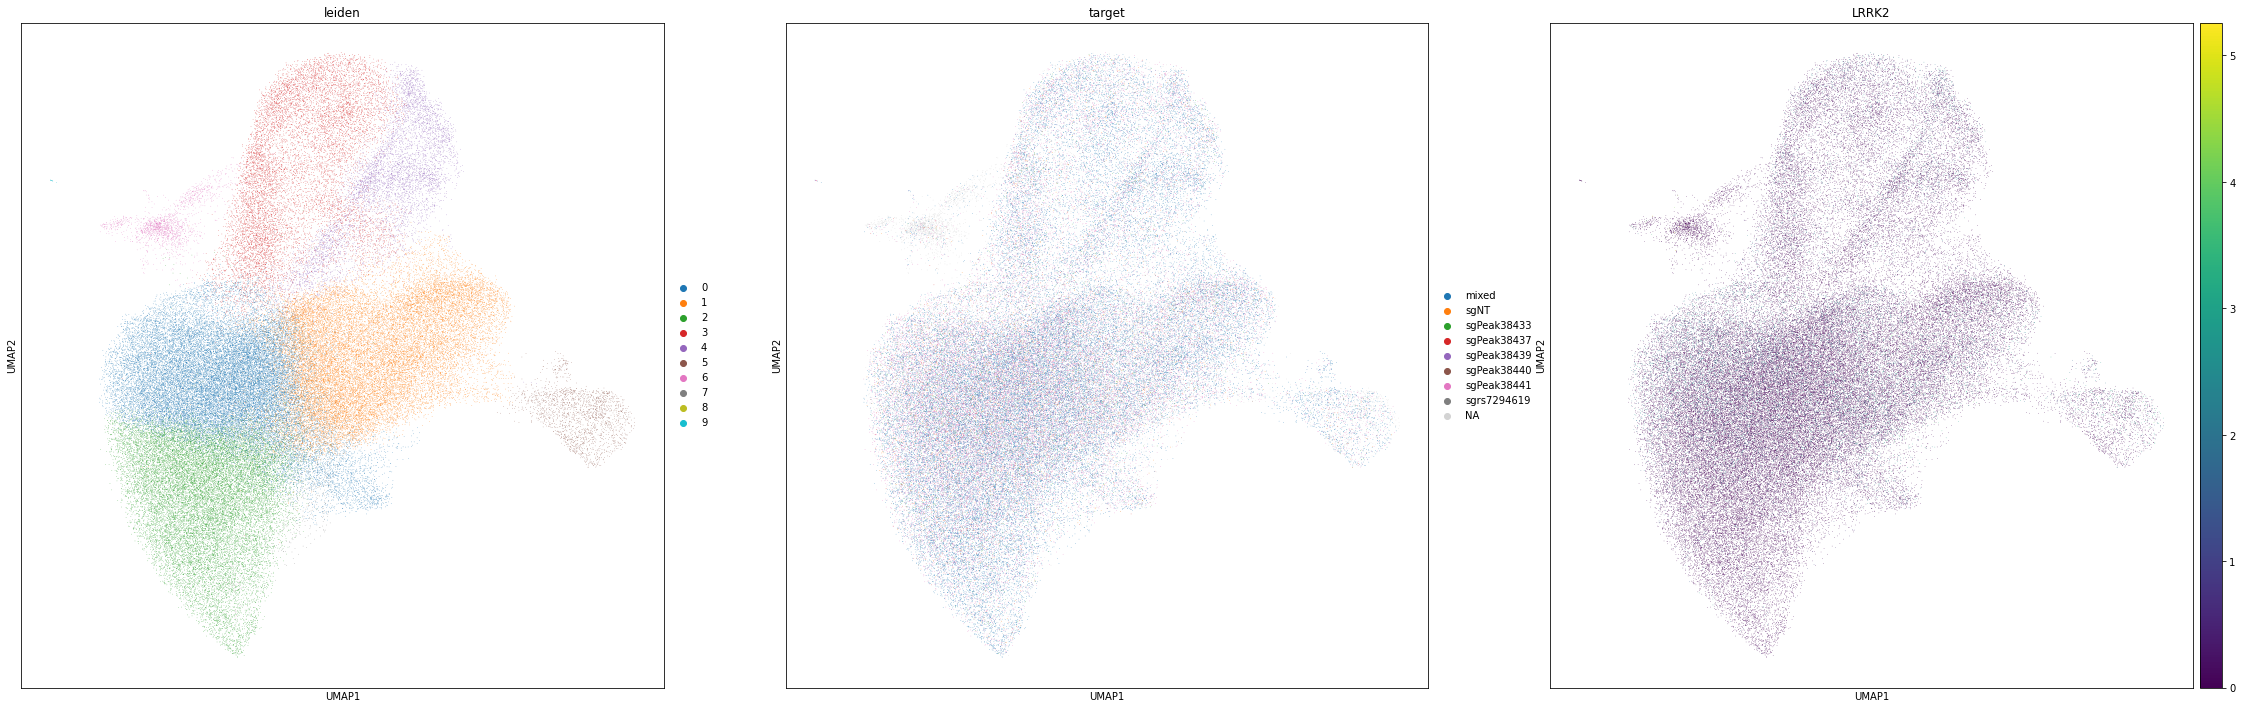

In [8]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=['leiden', 'target', 'LRRK2'])

#### export the existing UMAP data to dataframe with obs info for external plotting

(94109, 14)


UMAP-1     UMAP-2   expr_name  num_features  \
AAACCCAAGACTACGG-1  3.014447   2.249997  ci1-gex-fb           NaN   
AAACCCAAGCACTAAA-1 -1.209991  -4.595076  ci1-gex-fb           3.0   
AAACCCAAGCCGGAAT-1 -4.476950   3.888669  ci1-gex-fb           4.0   
AAACCCAAGGCTCAAG-1  0.780149  10.380839  ci1-gex-fb           2.0   
AAACCCAAGTTTGCTG-1 -2.872787   4.721696  ci1-gex-fb           4.0   

                                                         feature_call  \
AAACCCAAGACTACGG-1                                                NaN   
AAACCCAAGCACTAAA-1     sgPeak38437_29|sgPeak38441_134|sgPeak38441_319   
AAACCCAAGCCGGAAT-1  sgPeak38441_211|sgPeak38441_310|sgPeak38441_33...   
AAACCCAAGGCTCAAG-1                     sgPeak38441_04|sgPeak38441_266   
AAACCCAAGTTTGCTG-1     sgNT_24|sgNT_49|sgPeak38433_38|sgPeak38441_196   

                       num_umis       target   celltype  n_genes_by_counts  \
AAACCCAAGACTACGG-1          NaN          NaN  Micro-PVM               2208   
AAACCCAAGCACTAAA-1   314|13|230        mixed  Micro-PVM               4996   
AAACCCAAGCCGGAAT-1  136|5|69|25  sgPeak38441  Micro-PVM               4591   
AAACCCAAGGCTCAAG-1        13|31  sgPeak38441  Micro-PVM               5753   
AAACCCAAGTTTGCTG-1    4|9|14|16        mixed  Micro-PVM               3745   

                    total_counts  total_counts_mt  pct_counts_mt  n_genes  \
AAACCCAAGACTACGG-1        7911.0            534.0       6.750095     2208   
AAACCCAAGCACTAAA-1       27407.0           1479.0       5.396432     4996   
AAACCCAAGCCGGAAT-1       26085.0           1379.0       5.286563     4591   
AAACCCAAGGCTCAAG-1       34377.0           2620.0       7.621375     5753   
AAACCCAAGTTTGCTG-1       14111.0            939.0       6.654383     3745   

                   leiden  
AAACCCAAGACTACGG-1      1  
AAACCCAAGCACTAAA-1      2  
AAACCCAAGCCGGAAT-1      0  
AAACCCAAGGCTCAAG-1      3  
AAACCCAAGTTTGCTG-1      0

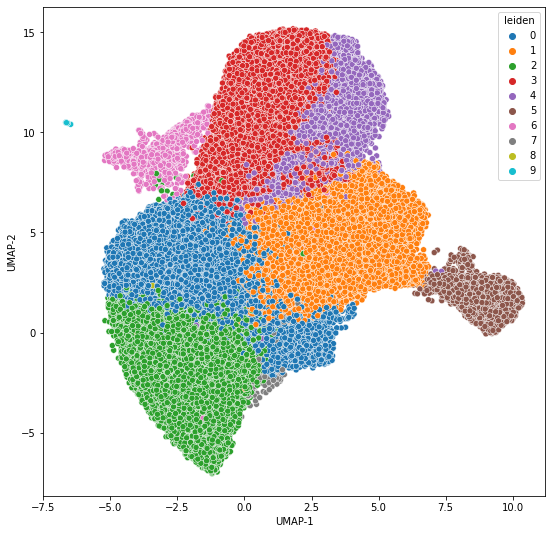

In [9]:
# get the umap values and add cell barcodes as index
umap_df = pd.DataFrame(data=adata.obsm['X_umap'], index=adata.obs.index, columns=['UMAP-1', 'UMAP-2'])
# since same indices can just concat the obs data on
umap_df = pd.concat([umap_df, adata.obs], axis='columns')
print(umap_df.shape)
display(umap_df.head())

with rc_context({'figure.figsize': (9, 9)}):
    sns.scatterplot(x='UMAP-1', y='UMAP-2', data=umap_df, hue='leiden')
    
# save the umap dataframe
umap_df.to_csv(umap_data_file)

#### subset the data based on cell-type and gene set

In [10]:
print(adata.obs['celltype'].value_counts())

Micro-PVM    93748
Astro          361
Name: celltype, dtype: int64


In [11]:
print('PRKN' in adata.var.head().index.to_list())
print('PARK2' in adata.var.head().index.to_list())

False
False


In [12]:
# make a copy since subset is probably small to full is large and takes a while to load
genes_oi_in_data = list(set(genes_oi) & set(adata.var.index))
subdata = adata[:, genes_oi_in_data].copy()
subdata = subdata[subdata.obs.celltype.isin(['Micro-PVM'])]
print(subdata)

View of AnnData object with n_obs × n_vars = 93748 × 42
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'target_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [13]:
'IL8' in adata.var.index.values

False

In [14]:
print(subdata.obs['celltype'].value_counts())

Micro-PVM    93748
Name: celltype, dtype: int64


### perform tests for difference by target

#### convert the subset anndata to pandas data for easier analysis and drop cells with missing obs data

In [15]:
# convert anndata to pandas dataframe
obs_features = ['expr_name', 'num_features', 'feature_call', 'target', 
                'total_counts', 'pct_counts_mt']
sub_df = convert_ad_to_df(subdata, obs_features)

# drop cells with missing obs for guide and targert
print(sub_df.shape)
sub_df = sub_df.loc[sub_df.num_features.notnull()]
print(sub_df.shape)

(93748, 48)
(76686, 48)


#### scale the gene of interest (LRRK2) [0, 1]

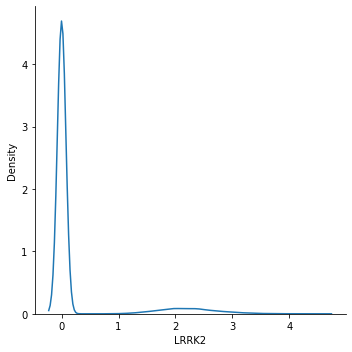

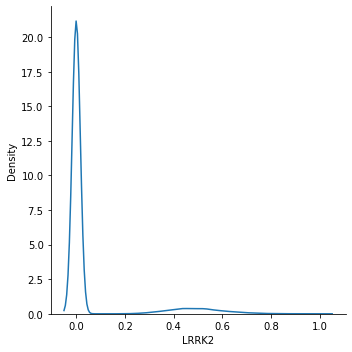

In [16]:
# sub_df[gene_oi] =  MinMaxScaler().fit_transform(RobustScaler(quantile_range=(25, 75))
#                                                   .fit_transform(sub_df[[gene_oi]]))
# density before
sns.displot(sub_df, x=gene_oi, kind='kde')

sub_df[gene_oi] =  MinMaxScaler().fit_transform(sub_df[[gene_oi]])

# density after
sns.displot(sub_df, x=gene_oi, kind='kde')

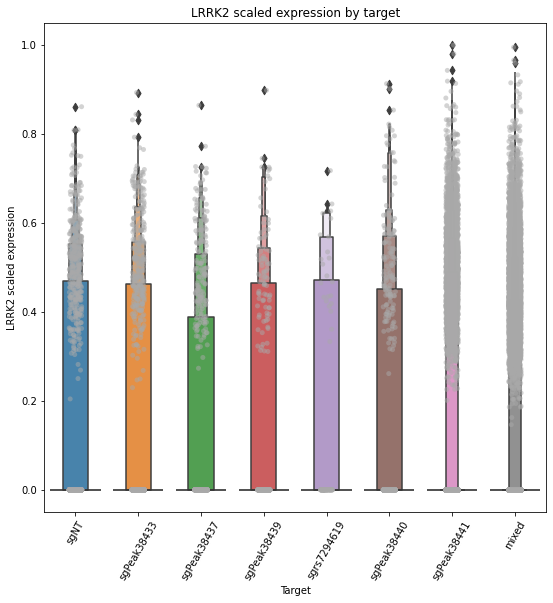

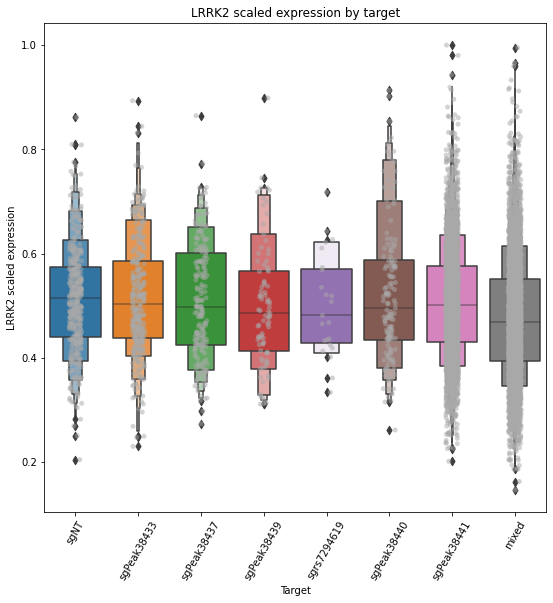

In [17]:
plot_ordered_targets(gene_oi, sub_df, ordered_targets)
plot_ordered_targets(gene_oi, sub_df, ordered_targets, drop_zeros=True)

In [18]:
sub_df.loc[sub_df.target != 'mixed']['target'].value_counts()

sgPeak38441    25864
sgNT            2122
sgPeak38433     1634
sgPeak38437     1284
sgPeak38440      764
sgPeak38439      406
sgrs7294619       95
mixed              0
Name: target, dtype: int64

#### quick general model of all targets together

In [19]:
# indep features: 'feature_call','target'
sub_df['targeted'] = np.where(sub_df.target.isin(['mixed', 'sgNT']), 0, 1)
this_formula = f'Q("{gene_oi}") ~ C(target) + C(expr_name) + total_counts + pct_counts_mt + num_features'
# conert anndata to pandas dataframe
# run GLM via statsmodel
result = glm_model(this_formula, sub_df.loc[sub_df.target != 'mixed'])
print(result.summary())
# result = glm_model(this_formula, sub_df, use_tweedie=False)
# print(result.summary())
this_formula = f'Q("{gene_oi}") ~ targeted + C(expr_name) + total_counts + pct_counts_mt + num_features'
result = glm_model(this_formula, sub_df.loc[sub_df.target != 'mixed'])
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Q("LRRK2")   No. Observations:                32169
Model:                            GLM   Df Residuals:                    32157
Model Family:                 Tweedie   Df Model:                           11
Link Function:                    log   Scale:                          2.5649
Method:                          IRLS   Log-Likelihood:                 14634.
Date:                Fri, 18 Feb 2022   Deviance:                       62760.
Time:                        13:24:38   Pearson chi2:                 8.25e+04
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

#### adjust trait's residuals after modeling covariates, via linear regression

will still run the unadjust trait and covairates in the model but get a look at trait adjusted for the covariates

In [20]:
sub_df[f'adj_{gene_oi}'], covar_score = covariate_adjusted(sub_df, gene_oi)

0.010606524771239134


<Figure size 432x432 with 0 Axes>

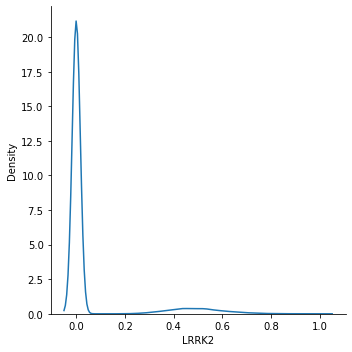

<Figure size 432x432 with 0 Axes>

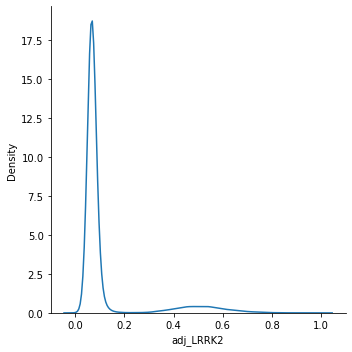

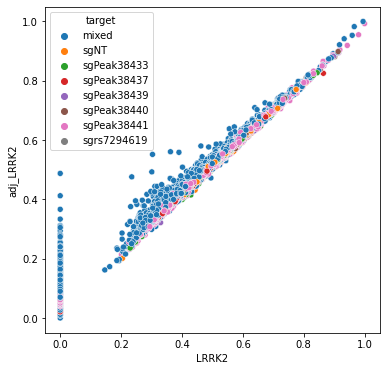

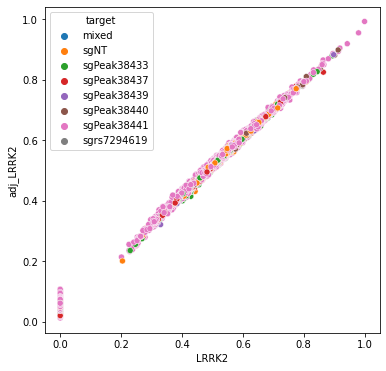

In [21]:
print(covar_score)
plt.figure(figsize=(6,6))
sns.displot(sub_df, x=gene_oi, kind='kde')
plt.show()
plt.figure(figsize=(6,6))
sns.displot(sub_df, x=f'adj_{gene_oi}', kind='kde')
plt.show()
plt.figure(figsize=(6,6))
sns.scatterplot(data=sub_df, x=gene_oi, y=f'adj_{gene_oi}', hue='target')
plt.show()
plt.figure(figsize=(6,6))
sns.scatterplot(data=sub_df.loc[sub_df.target != 'mixed'], 
                x=gene_oi, y=f'adj_{gene_oi}', hue='target')
plt.show()


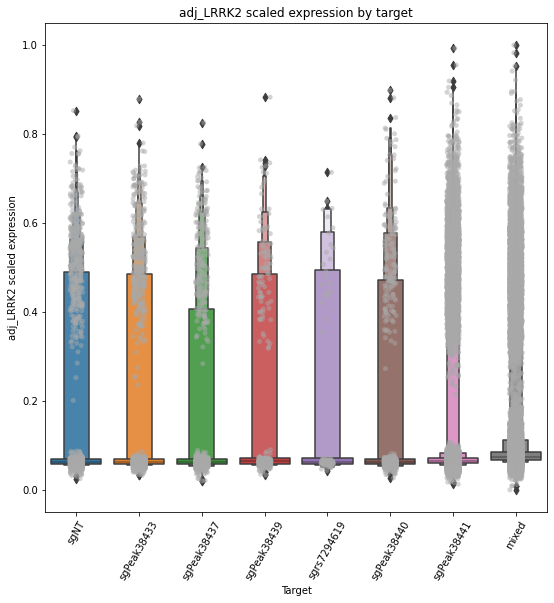

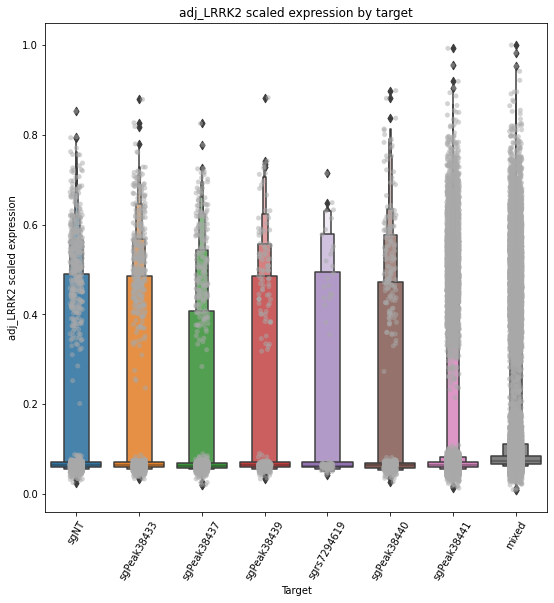

In [22]:
plot_ordered_targets(f'adj_{gene_oi}', sub_df, ordered_targets)
plot_ordered_targets(f'adj_{gene_oi}', sub_df, ordered_targets, drop_zeros=True)

#### export figure with some addl formatting for potential supplemental inclusion

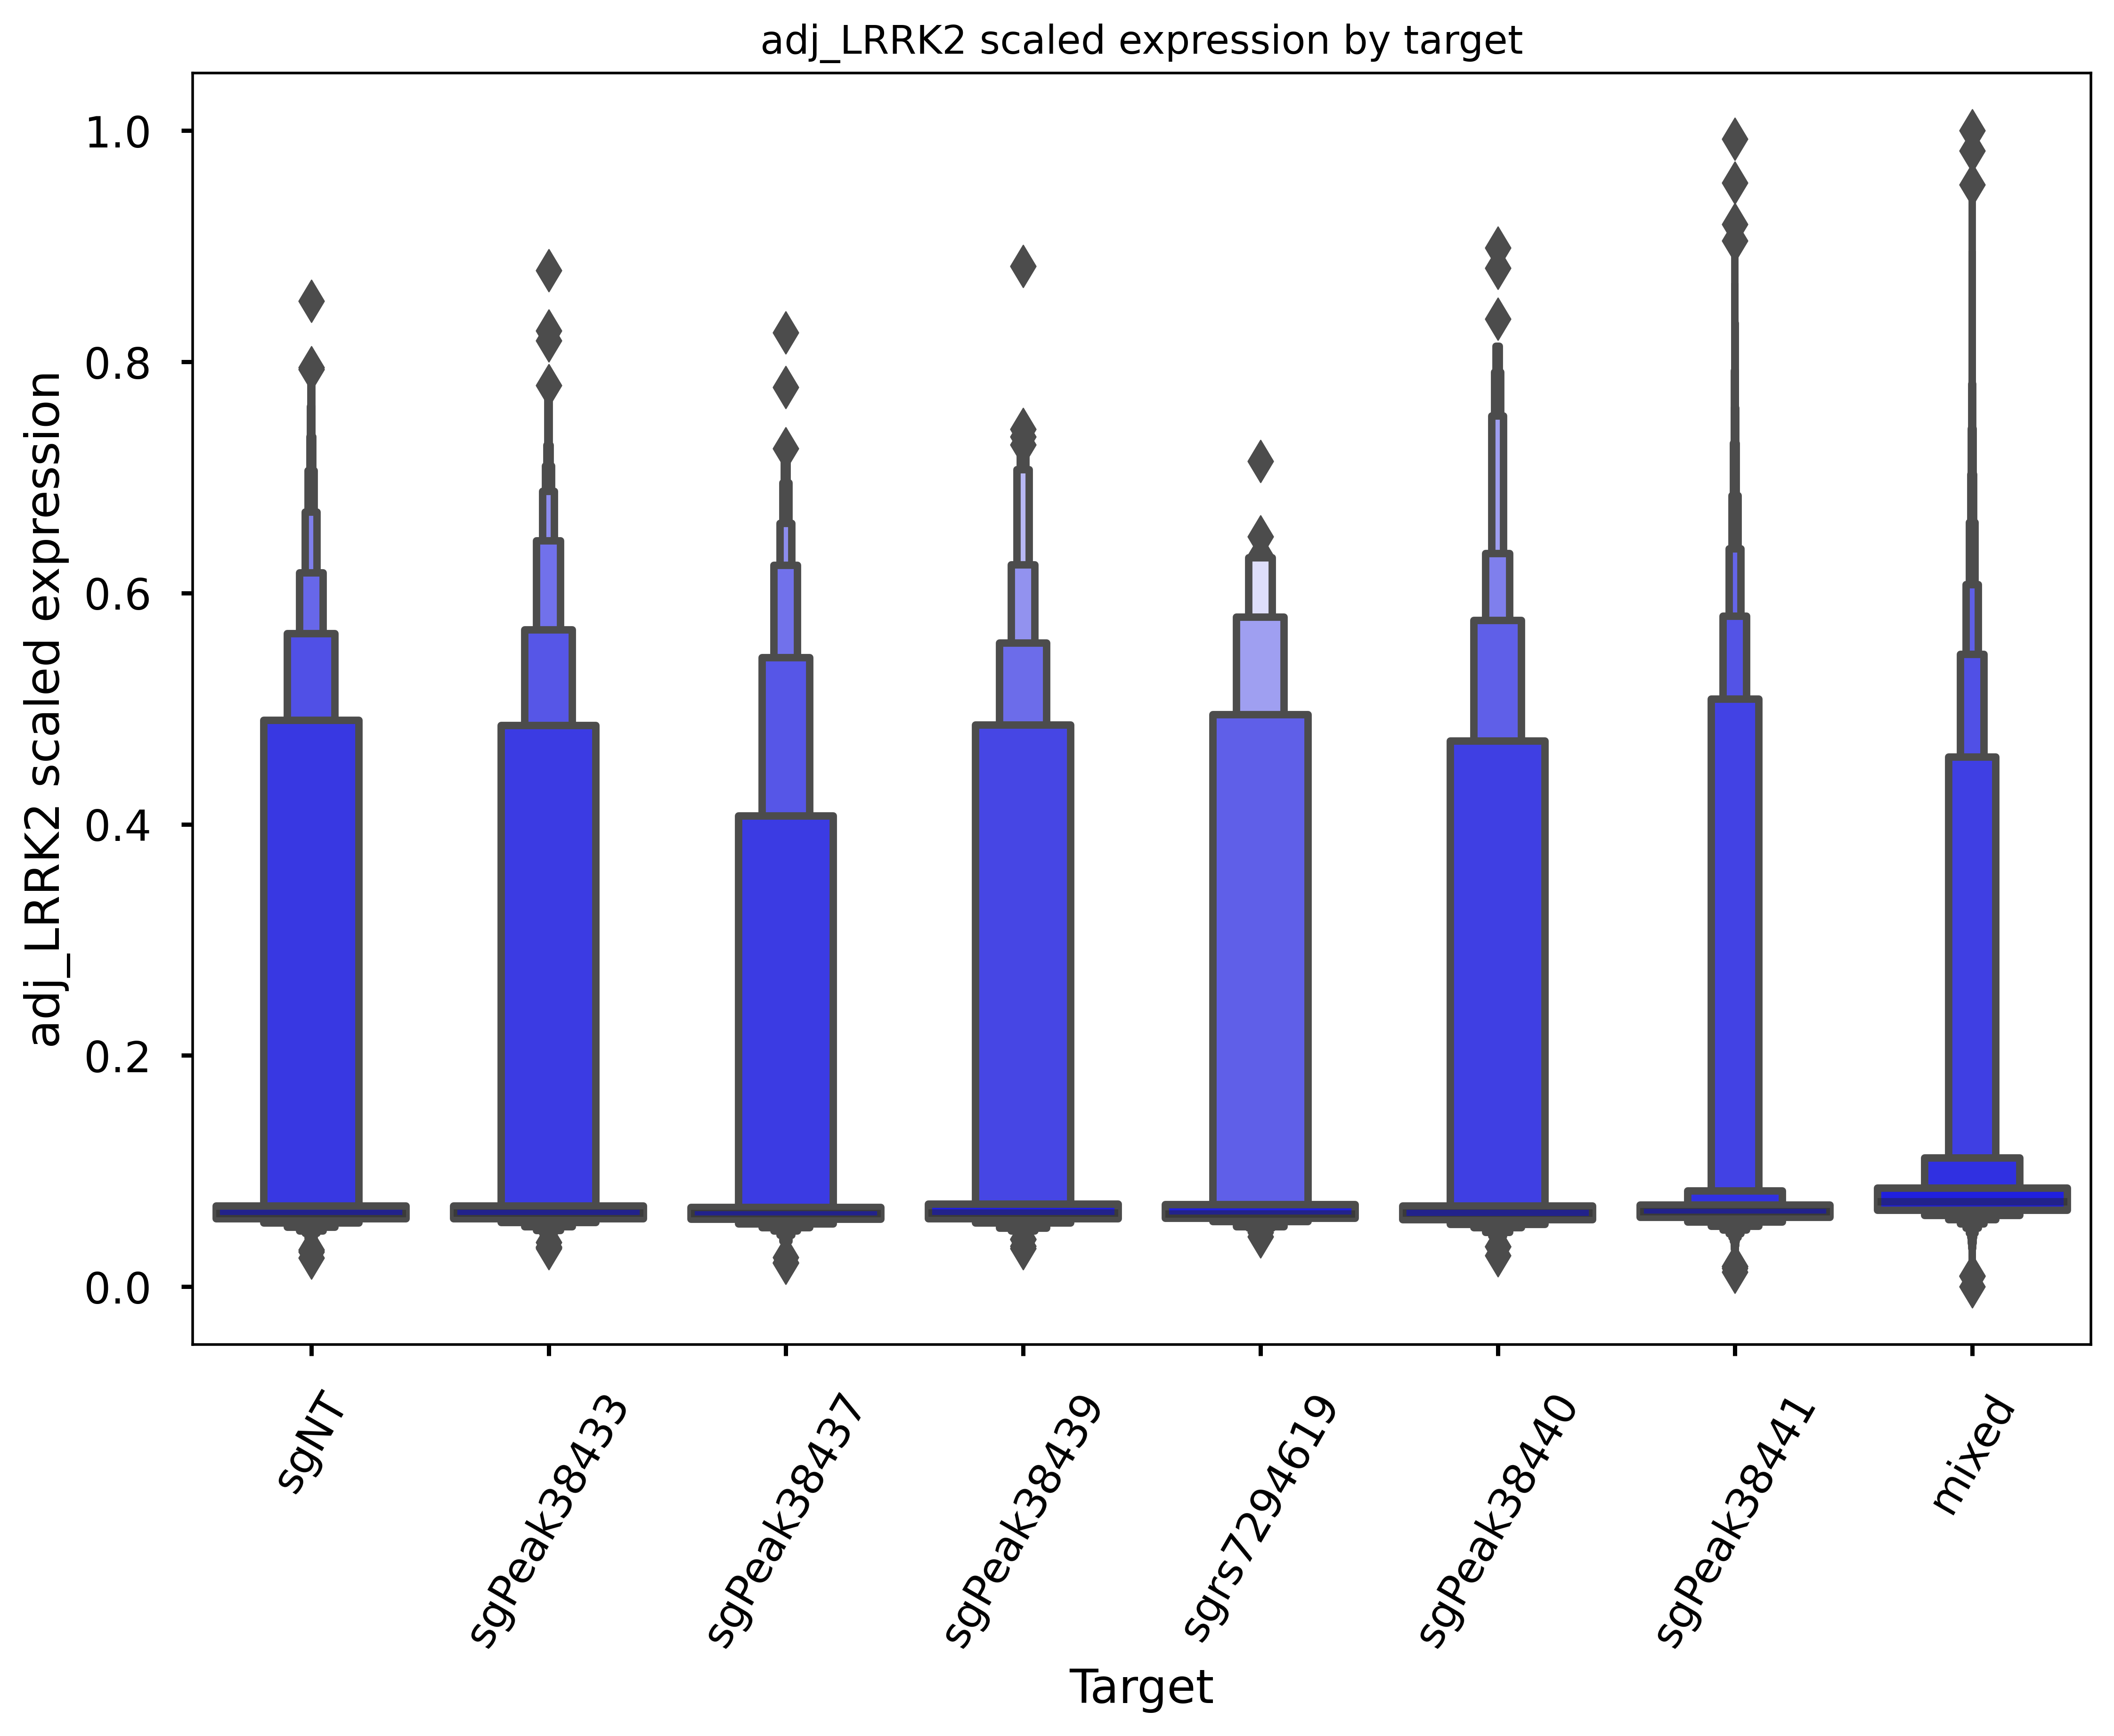

In [23]:
gene = f'adj_{gene_oi}'
# gene = gene_oi
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': 500}):
    plt.style.use('seaborn-talk')
    thisplt = sns.boxenplot(x='target',y=gene, scale='exponential', data=sub_df,
                            k_depth='trustworthy', order=ordered_targets, color='blue')
    loc, labels = plt.xticks()
    thisplt.set_xticklabels(labels, rotation=60)
    plt.title(f'{gene} scaled expression by target', fontsize='large') 
    plt.xlabel('Target')
    plt.ylabel(f'{gene} scaled expression')
    plt.subplots_adjust(wspace=0.3)
#     plt.show()
    plt.savefig(fname=f'{wrk_dir}/{cohort}.target.boxenplots.svg', format='svg')                    
              

### model LRRK2 expression for each target

peaks and elements the CRISPR guides were designed to target

In [24]:
# for each target run targeted versus non-targeted
this_formula = f'Q("{gene_oi}") ~ targeted + C(expr_name) + total_counts + pct_counts_mt + num_features'
targets_oi = ['sgPeak38433', 'sgPeak38437', 'sgPeak38439', 
              'sgrs7294619', 'sgPeak38440', 'sgPeak38441']
keep_features = obs_features + ['targeted', gene_oi, f'adj_{gene_oi}']
results = []
for target in targets_oi:
    target_df = sub_df.loc[sub_df.target.isin([target, 'sgNT']), keep_features]
    # run GLM via statsmodel
    result = glm_model(this_formula, target_df)
    # if you want to spill full summary to notebook uncomment the prints
#     print(target)
#     print(result.summary())
    counts = target_df.targeted.value_counts()
    t_cnt = counts[1]
    nt_cnt = counts[0]
    ret_list = [gene_oi, target, result.params['Intercept'], 
                result.params['targeted'], result.bse['targeted'], 
                result.tvalues['targeted'], result.pvalues['targeted'], 
                t_cnt, nt_cnt]  
    results.append(ret_list)
    
results_df = pd.DataFrame(data=results, 
                          columns=['dep', 'indep', 'intercept', 'coef', 
                                   'stderr', 'z', 'p-value', 't_cnt', 'nt_cnt']) 
print(results_df.shape)
display(results_df)

(6, 9)


dep        indep  intercept      coef    stderr         z       p-value  \
0  LRRK2  sgPeak38433  -2.807265  0.039107  0.069968  0.558922  5.762149e-01   
1  LRRK2  sgPeak38437  -3.084057 -0.253705  0.081983 -3.094588  1.970867e-03   
2  LRRK2  sgPeak38439  -2.858130  0.114473  0.113538  1.008235  3.133419e-01   
3  LRRK2  sgrs7294619  -2.873818  0.215134  0.214932  1.000941  3.168555e-01   
4  LRRK2  sgPeak38440  -2.823076  0.030712  0.090247  0.340313  7.336212e-01   
5  LRRK2  sgPeak38441  -2.612448 -0.367067  0.060409 -6.076406  1.229059e-09   

   t_cnt  nt_cnt  
0   1634    2122  
1   1284    2122  
2    406    2122  
3     95    2122  
4    764    2122  
5  25864    2122

#### save the results for the targets

In [25]:
results_df.to_csv(targets_results_file, index=False)

### model LRRK2 expression for each guide

#### subset data to just cells that had a single guide present

In [26]:
guide_df = sub_df.loc[sub_df.num_features == 1]
print(guide_df.shape)
print(guide_df.feature_call.nunique())

(18104, 50)
533


#### visualize LRRK2 expression by guide

In [27]:
%%time
# this takes so long it doesn't finish in a reasonable amout of time
# plot_guides(gene_oi, guide_df)
# plot_guides(f'adj_{gene_oi}', guide_df)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


#### models the guides

In [28]:
# for each guide run model versus non-targeted
# pretty much the same formula but different subset df's
# but here each cell only has single guide; ie num_features = 1 for all so drop
this_formula = f'Q("{gene_oi}") ~ targeted + C(expr_name) + total_counts + pct_counts_mt'
# get the targeted guides
guides = guide_df.loc[guide_df.targeted == 1].feature_call.unique()
keep_features = obs_features + ['targeted', gene_oi, f'adj_{gene_oi}']
results = []
for guide in guides:
    sg_df = guide_df.loc[(guide_df.feature_call == guide) | 
                         (guide_df.target == 'sgNT'), keep_features]
    # run GLM via statsmodel
    result = glm_model(this_formula, sg_df)
    counts = sg_df.targeted.value_counts()
    t_cnt = counts[1]
    nt_cnt = counts[0]
    ret_list = [gene_oi, guide, result.params['Intercept'], 
                result.params['targeted'], result.bse['targeted'], 
                result.tvalues['targeted'], result.pvalues['targeted'], 
                t_cnt, nt_cnt]  
    results.append(ret_list)
    
results_df = pd.DataFrame(data=results, 
                          columns=['dep', 'indep', 'intercept', 'coef', 
                                   'stderr', 'z', 'p-value', 't_cnt', 'nt_cnt']) 
print(results_df.shape)
display(results_df)

(483, 9)


dep            indep  intercept       coef     stderr         z  \
0    LRRK2   sgPeak38441_95  -2.912132   0.032634   0.421406  0.077440   
1    LRRK2   sgPeak38440_11  -2.895612  -0.112320   0.430248 -0.261059   
2    LRRK2  sgPeak38441_320  -2.950215  -1.231271   0.529881 -2.323675   
3    LRRK2  sgPeak38441_195  -2.890899  -1.298721   0.413088 -3.143936   
4    LRRK2   sgPeak38433_26  -2.878114   0.658401   0.374081  1.760049   
..     ...              ...        ...        ...        ...       ...   
478  LRRK2   sgPeak38433_35  -2.909991 -37.080965  42.156915 -0.879594   
479  LRRK2  sgPeak38441_333  -2.892882   0.154085   0.616612  0.249890   
480  LRRK2  sgPeak38441_221  -2.909991 -37.935347  14.008929 -2.707941   
481  LRRK2  sgPeak38441_232  -2.911080  -0.393031   0.495766 -0.792775   
482  LRRK2   sgPeak38441_74  -2.909991 -36.733233  50.336298 -0.729756   

      p-value  t_cnt  nt_cnt  
0    0.938273     26    1938  
1    0.794047     26    1938  
2    0.020143     27    1938  
3    0.001667     47    1938  
4    0.078399     25    1938  
..        ...    ...     ...  
478  0.379079      9    1938  
479  0.802673     11    1938  
480  0.006770     19    1938  
481  0.427909     22    1938  
482  0.465539     11    1938  

[483 rows x 9 columns]

#### compute the fdr for the results

In [29]:
results_df = compute_bh_fdr(results_df)

total significant after correction: (28, 10)


In [30]:
results_df.loc[results_df.fdr_bh < 0.05].sort_values(by=['fdr_bh'])

dep            indep  intercept       coef    stderr         z  \
65   LRRK2  sgPeak38441_268  -2.872121  -2.163859  0.462633 -4.677268   
278  LRRK2  sgPeak38441_148  -2.877828  -1.884589  0.435321 -4.329195   
306  LRRK2  sgPeak38441_250  -2.915903  -2.034508  0.503142 -4.043609   
351  LRRK2  sgPeak38441_203  -2.917643  -1.925433  0.466927 -4.123630   
144  LRRK2   sgPeak38437_25  -3.014582  -2.536826  0.621045 -4.084768   
287  LRRK2  sgPeak38441_197  -2.909991 -37.950323  9.350960 -4.058441   
381  LRRK2  sgPeak38441_188  -2.909991 -37.910017  9.479044 -3.999350   
130  LRRK2  sgPeak38441_223  -2.948052  -1.849947  0.470643 -3.930679   
119  LRRK2  sgPeak38441_103  -3.080428  -1.269962  0.327859 -3.873505   
36   LRRK2  sgPeak38441_157  -2.931768  -2.038611  0.551029 -3.699642   
73   LRRK2   sgPeak38441_15  -2.967048  -2.230967  0.610526 -3.654173   
169  LRRK2  sgPeak38441_215  -2.525437  -1.762103  0.487472 -3.614775   
105  LRRK2  sgPeak38441_164  -3.027090  -1.792564  0.497947 -3.599911   
120  LRRK2  sgPeak38441_183  -2.937863  -1.975028  0.558511 -3.536238   
382  LRRK2  sgPeak38441_189  -2.957830  -1.880358  0.538620 -3.491065   
362  LRRK2   sgPeak38441_06  -2.882377  -1.847155  0.538381 -3.430946   
47   LRRK2  sgPeak38441_193  -2.912451  -1.765279  0.514802 -3.429046   
236  LRRK2  sgPeak38441_201  -2.793088  -1.835693  0.539551 -3.402261   
108  LRRK2   sgPeak38441_04  -2.913868  -1.411338  0.422005 -3.344364   
438  LRRK2  sgPeak38441_349  -2.949229  -2.191256  0.658450 -3.327900   
370  LRRK2   sgPeak38433_43  -2.900165   0.897182  0.273564  3.279607   
224  LRRK2   sgPeak38441_24  -2.860677  -2.071114  0.629644 -3.289342   
355  LRRK2  sgPeak38441_252  -2.877256  -1.515396  0.464356 -3.263438   
398  LRRK2   sgPeak38433_36  -2.865217  -1.806422  0.559761 -3.227130   
3    LRRK2  sgPeak38441_195  -2.890899  -1.298721  0.413088 -3.143936   
85   LRRK2  sgPeak38441_202  -2.954052  -1.696026  0.553753 -3.062783   
153  LRRK2  sgPeak38441_286  -2.932599  -1.623443  0.534922 -3.034915   
420  LRRK2  sgPeak38441_325  -2.981186  -1.408714  0.467674 -3.012169   

      p-value  t_cnt  nt_cnt    fdr_bh  
65   0.000003     54    1938  0.001404  
278  0.000015     55    1938  0.003614  
306  0.000053     44    1938  0.004237  
351  0.000037     51    1938  0.004237  
144  0.000044     34    1938  0.004237  
287  0.000049     42    1938  0.004237  
381  0.000064     41    1938  0.004383  
130  0.000085     45    1938  0.005114  
119  0.000107     76    1938  0.005757  
36   0.000216     36    1938  0.010428  
73   0.000258     31    1938  0.011329  
169  0.000301     42    1938  0.011827  
105  0.000318     39    1938  0.011827  
120  0.000406     34    1938  0.014002  
382  0.000481     35    1938  0.015491  
362  0.000601     35    1938  0.017209  
47   0.000606     37    1938  0.017209  
236  0.000668     35    1938  0.017933  
108  0.000825     48    1938  0.020965  
438  0.000875     26    1938  0.021132  
370  0.001040     43    1938  0.022822  
224  0.001004     27    1938  0.022822  
355  0.001101     41    1938  0.023115  
398  0.001250     32    1938  0.025164  
3    0.001667     47    1938  0.032205  
85   0.002193     31    1938  0.040737  
153  0.002406     32    1938  0.043041  
420  0.002594     39    1938  0.044744

In [31]:
results_df.loc[results_df.fdr_bh < 0.05].sort_values(by=['coef'])

dep            indep  intercept       coef    stderr         z  \
287  LRRK2  sgPeak38441_197  -2.909991 -37.950323  9.350960 -4.058441   
381  LRRK2  sgPeak38441_188  -2.909991 -37.910017  9.479044 -3.999350   
144  LRRK2   sgPeak38437_25  -3.014582  -2.536826  0.621045 -4.084768   
73   LRRK2   sgPeak38441_15  -2.967048  -2.230967  0.610526 -3.654173   
438  LRRK2  sgPeak38441_349  -2.949229  -2.191256  0.658450 -3.327900   
65   LRRK2  sgPeak38441_268  -2.872121  -2.163859  0.462633 -4.677268   
224  LRRK2   sgPeak38441_24  -2.860677  -2.071114  0.629644 -3.289342   
36   LRRK2  sgPeak38441_157  -2.931768  -2.038611  0.551029 -3.699642   
306  LRRK2  sgPeak38441_250  -2.915903  -2.034508  0.503142 -4.043609   
120  LRRK2  sgPeak38441_183  -2.937863  -1.975028  0.558511 -3.536238   
351  LRRK2  sgPeak38441_203  -2.917643  -1.925433  0.466927 -4.123630   
278  LRRK2  sgPeak38441_148  -2.877828  -1.884589  0.435321 -4.329195   
382  LRRK2  sgPeak38441_189  -2.957830  -1.880358  0.538620 -3.491065   
130  LRRK2  sgPeak38441_223  -2.948052  -1.849947  0.470643 -3.930679   
362  LRRK2   sgPeak38441_06  -2.882377  -1.847155  0.538381 -3.430946   
236  LRRK2  sgPeak38441_201  -2.793088  -1.835693  0.539551 -3.402261   
398  LRRK2   sgPeak38433_36  -2.865217  -1.806422  0.559761 -3.227130   
105  LRRK2  sgPeak38441_164  -3.027090  -1.792564  0.497947 -3.599911   
47   LRRK2  sgPeak38441_193  -2.912451  -1.765279  0.514802 -3.429046   
169  LRRK2  sgPeak38441_215  -2.525437  -1.762103  0.487472 -3.614775   
85   LRRK2  sgPeak38441_202  -2.954052  -1.696026  0.553753 -3.062783   
153  LRRK2  sgPeak38441_286  -2.932599  -1.623443  0.534922 -3.034915   
355  LRRK2  sgPeak38441_252  -2.877256  -1.515396  0.464356 -3.263438   
108  LRRK2   sgPeak38441_04  -2.913868  -1.411338  0.422005 -3.344364   
420  LRRK2  sgPeak38441_325  -2.981186  -1.408714  0.467674 -3.012169   
3    LRRK2  sgPeak38441_195  -2.890899  -1.298721  0.413088 -3.143936   
119  LRRK2  sgPeak38441_103  -3.080428  -1.269962  0.327859 -3.873505   
370  LRRK2   sgPeak38433_43  -2.900165   0.897182  0.273564  3.279607   

      p-value  t_cnt  nt_cnt    fdr_bh  
287  0.000049     42    1938  0.004237  
381  0.000064     41    1938  0.004383  
144  0.000044     34    1938  0.004237  
73   0.000258     31    1938  0.011329  
438  0.000875     26    1938  0.021132  
65   0.000003     54    1938  0.001404  
224  0.001004     27    1938  0.022822  
36   0.000216     36    1938  0.010428  
306  0.000053     44    1938  0.004237  
120  0.000406     34    1938  0.014002  
351  0.000037     51    1938  0.004237  
278  0.000015     55    1938  0.003614  
382  0.000481     35    1938  0.015491  
130  0.000085     45    1938  0.005114  
362  0.000601     35    1938  0.017209  
236  0.000668     35    1938  0.017933  
398  0.001250     32    1938  0.025164  
105  0.000318     39    1938  0.011827  
47   0.000606     37    1938  0.017209  
169  0.000301     42    1938  0.011827  
85   0.002193     31    1938  0.040737  
153  0.002406     32    1938  0.043041  
355  0.001101     41    1938  0.023115  
108  0.000825     48    1938  0.020965  
420  0.002594     39    1938  0.044744  
3    0.001667     47    1938  0.032205  
119  0.000107     76    1938  0.005757  
370  0.001040     43    1938  0.022822

#### save the results for the guides

In [32]:
results_df.to_csv(guides_results_file, index=False)

#### save the data used in the models

In [34]:
sub_df.columns

Index(['TNF', 'FBXO7', 'HTRA2', 'TGFB1', 'LPL', 'GIGYF2', 'SPP1', 'ITGAX',
       'TMEM119', 'TGFBR1', 'AIF1', 'DNAJC16', 'DNAJC6', 'SNCA', 'FCGR2A',
       'P2RY12', 'RGS10', 'CCL4', 'PARK7', 'ATP13A2', 'LRRK2', 'UCHL1', 'CTSS',
       'APOE', 'CD86', 'PINK1', 'PLA2G6', 'VPS35', 'DOCK8', 'CST7', 'CD74',
       'CXCL8', 'CX3CR1', 'IL1B', 'CSF1R', 'CD68', 'EIF4G1', 'ITGAM', 'CCL3',
       'MAPT', 'GBA', 'CSF1', 'expr_name', 'num_features', 'feature_call',
       'target', 'total_counts', 'pct_counts_mt', 'targeted', 'adj_LRRK2'],
      dtype='object')

In [35]:
analyses_cols = [gene_oi, f'adj_{gene_oi}', 'targeted'] + obs_features
sub_df[analyses_cols].to_csv(gene_data_file)

#### save LRRK2 plus microglia markers used in previous Figure S5

In [36]:
# convert anndata to pandas dataframe again to make sure not including additional transforms
export_df = convert_ad_to_df(subdata, obs_features)
# drop cells with missing obs for guide and targert
print(export_df.shape)
export_df = export_df.loc[export_df.num_features.notnull()]
print(export_df.shape)
analyses_cols = [gene_oi] + obs_features + fig_s5_markers
analyses_cols = list(set(analyses_cols) & set(export_df.columns))
print(set(fig_s5_markers) - set(analyses_cols))
export_df[analyses_cols].to_csv(figS5_data_file)

(93748, 48)
(76686, 48)
set()


## done

In [37]:
!date

Fri Feb 18 13:32:21 EST 2022


#### look specifically at sgPeak38437_30

In [38]:
this_guide = 'sgPeak38437_30'
results_df.loc[results_df.indep == this_guide]

dep           indep  intercept      coef    stderr        z   p-value  \
28  LRRK2  sgPeak38437_30  -2.938638 -1.245002  0.441205 -2.82182  0.004775   

    t_cnt  nt_cnt    fdr_bh  
28     41    1938  0.069891

In [39]:
results_df.shape

(483, 10)

In [40]:
guide_df.loc[guide_df.feature_call == this_guide].shape

(41, 50)

In [41]:
sub_df.loc[sub_df.feature_call == this_guide].shape

(41, 50)

In [42]:
# find all the cells that contain the specific guide
this_guide_obs = adata.obs.feature_call.str.contains(this_guide)
this_guide_obs = this_guide_obs.loc[this_guide_obs.notna()]
print(adata.obs.shape)
print(this_guide_obs.shape)
display(this_guide_obs.head())
print(this_guide_obs.value_counts())

(94109, 12)
(76757,)


AAACCCAAGCACTAAA-1    False
AAACCCAAGCCGGAAT-1    False
AAACCCAAGGCTCAAG-1    False
AAACCCAAGTTTGCTG-1    False
AAACCCACACTGGACC-1    False
Name: feature_call, dtype: object

False    76008
True       749
Name: feature_call, dtype: int64


target
mixed          0.116320
sgPeak38441    0.116368
sgPeak38437    0.130604
sgNT           0.149749
sgPeak38440    0.152004
Name: adj_LRRK2, dtype: float64

<AxesSubplot:xlabel='target'>

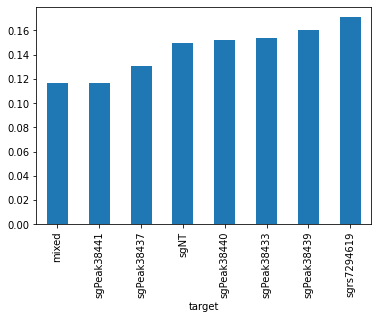

In [43]:
temp = sub_df.groupby('target', observed=True).adj_LRRK2.mean().sort_values()
display(temp.head())
temp.plot.bar()

feature_call
sgPeak38441_186    0.058177
sgPeak38441_158    0.059011
sgPeak38441_207    0.059084
sgPeak38441_263    0.059219
sgPeak38441_200    0.059614
Name: adj_LRRK2, dtype: float64

<AxesSubplot:xlabel='feature_call'>

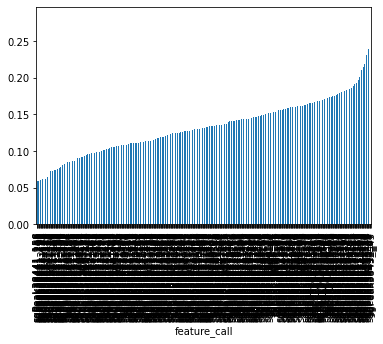

In [44]:
temp = guide_df.groupby('feature_call', observed=True).adj_LRRK2.mean().sort_values()
display(temp.head())
temp.plot.bar()

In [45]:
temp.to_frame().reset_index()

feature_call  adj_LRRK2
0    sgPeak38441_186   0.058177
1    sgPeak38441_158   0.059011
2    sgPeak38441_207   0.059084
3    sgPeak38441_263   0.059219
4    sgPeak38441_200   0.059614
..               ...        ...
528   sgPeak38433_26   0.239027
529   sgPeak38440_09   0.240674
530  sgPeak38441_337   0.249431
531   sgPeak38433_34   0.262333
532   sgPeak38433_43   0.283262

[533 rows x 2 columns]

#### show guide counts by target

In [46]:
temp = guide_df.groupby('target', observed=True).feature_call.value_counts().to_frame()
prev_value = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 1000)
display(temp.loc[temp.feature_call > 0])
pd.set_option('display.max_rows', prev_value)

feature_call
target                                   
sgPeak38441 sgPeak38441_196            91
            sgPeak38441_103            76
            sgPeak38441_140            69
            sgPeak38441_138            68
            sgPeak38441_149            68
            sgPeak38441_179            64
            sgPeak38441_26             62
            sgPeak38441_116            60
            sgPeak38441_85             59
            sgPeak38441_347            59
            sgPeak38441_119            58
            sgPeak38441_18             58
            sgPeak38441_212            58
            sgPeak38441_298            57
            sgPeak38441_245            57
            sgPeak38441_367            56
            sgPeak38441_91             56
            sgPeak38441_58             56
            sgPeak38441_181            56
            sgPeak38441_98             55
            sgPeak38441_148            55
            sgPeak38441_268            54
            sgPeak38441_354            54
            sgPeak38441_271            54
            sgPeak38441_356            52
            sgPeak38441_253            52
            sgPeak38441_08             52
            sgPeak38441_247            52
            sgPeak38441_203            51
            sgPeak38441_256            51
            sgPeak38441_211            51
            sgPeak38441_150            51
            sgPeak38441_308            51
            sgPeak38441_129            50
            sgPeak38441_20             50
            sgPeak38441_177            50
            sgPeak38441_102            50
            sgPeak38441_168            50
            sgPeak38441_88             50
            sgPeak38441_156            49
            sgPeak38441_77             49
            sgPeak38441_38             49
            sgPeak38441_78             48
            sgPeak38441_312            48
            sgPeak38441_07             48
            sgPeak38441_340            48
            sgPeak38441_365            48
            sgPeak38441_04             48
            sgPeak38441_254            48
            sgPeak38441_143            47
            sgPeak38441_34             47
            sgPeak38441_195            47
            sgPeak38441_01             47
            sgPeak38441_357            47
            sgPeak38441_219            47
            sgPeak38441_299            47
            sgPeak38441_224            47
            sgPeak38441_81             47
            sgPeak38441_342            46
            sgPeak38441_127            46
            sgPeak38441_75             45
            sgPeak38441_223            45
            sgPeak38441_255            45
            sgPeak38441_323            45
            sgPeak38441_97             45
            sgPeak38441_62             45
            sgPeak38441_284            45
            sgPeak38441_27             44
            sgPeak38441_52             44
            sgPeak38441_267            44
            sgPeak38441_250            44
            sgPeak38441_17             44
            sgPeak38441_288            44
            sgPeak38441_309            44
            sgPeak38441_35             44
            sgPeak38441_244            43
            sgPeak38441_360            43
            sgPeak38441_16             43
            sgPeak38441_278            43
            sgPeak38441_153            43
            sgPeak38441_353            43
            sgPeak38441_361            43
            sgPeak38441_30             43
            sgPeak38441_226            42
            sgPeak38441_155            42
            sgPeak38441_215            42
            sgPeak38441_236            42
            sgPeak38441_363            42
            sgPeak38441_324            42
            sgPeak38441_207            42
            sgPeak38441_51             42
            sgPeak38441_197            42
            sgPeak38441_25             42
            sgPeak38441_230            

## mess around with typical single-cell stuff but just for subset genes

### Principal component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [47]:
sc.tl.pca(subdata, svd_solver='arpack')

#### Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function 

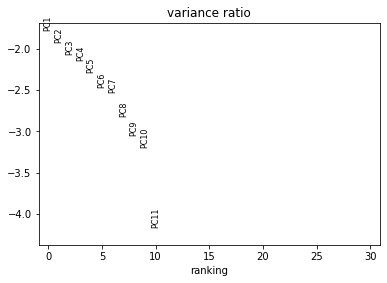

In [48]:
sc.pl.pca_variance_ratio(subdata, log=True)

### Computing the neighborhood graph
Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [49]:
sc.pp.neighbors(subdata)

### Embedding the neighborhood graph
We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

In [48]:
# sc.tl.paga(subdata)
# sc.pl.paga(subdata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(subdata, init_pos='paga')

In [50]:
sc.tl.umap(subdata)

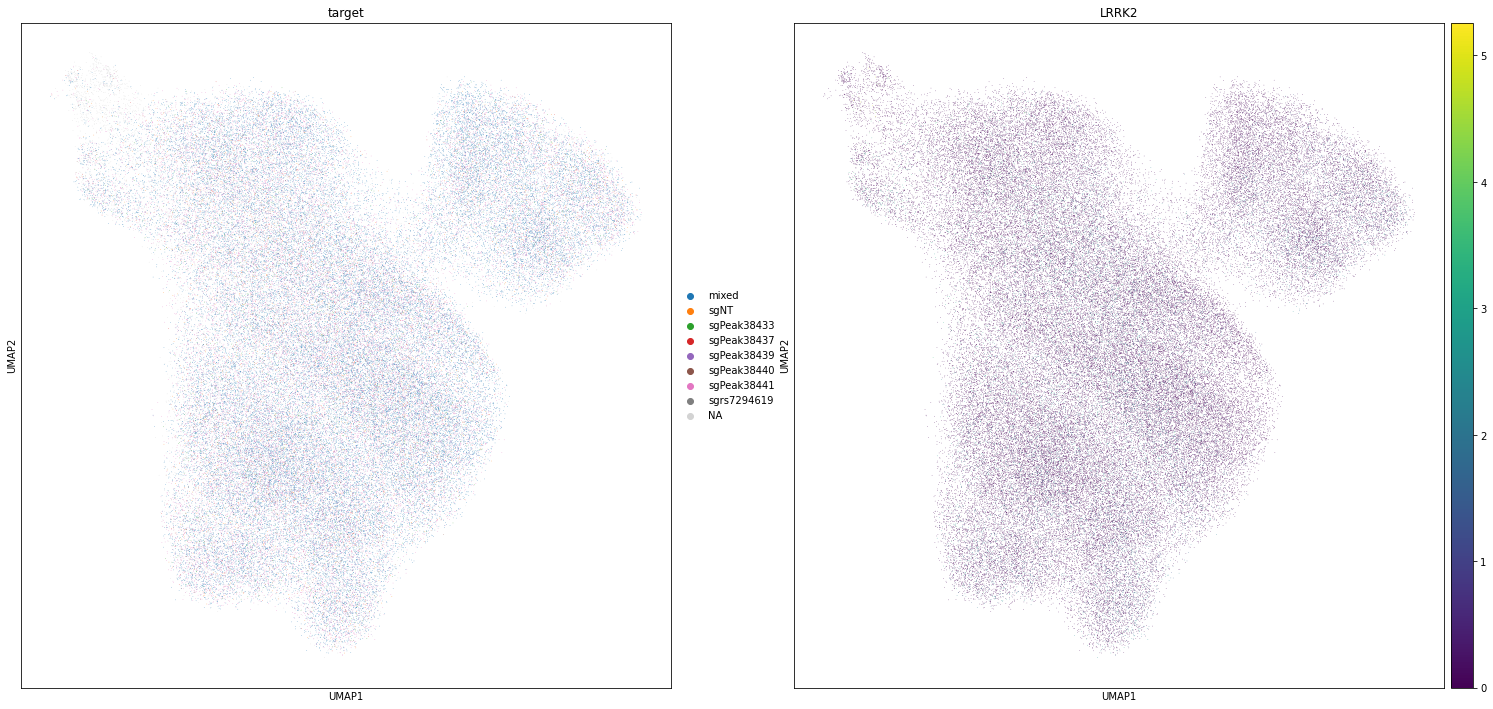

In [51]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(subdata, color=['target', 'LRRK2'])

#### As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

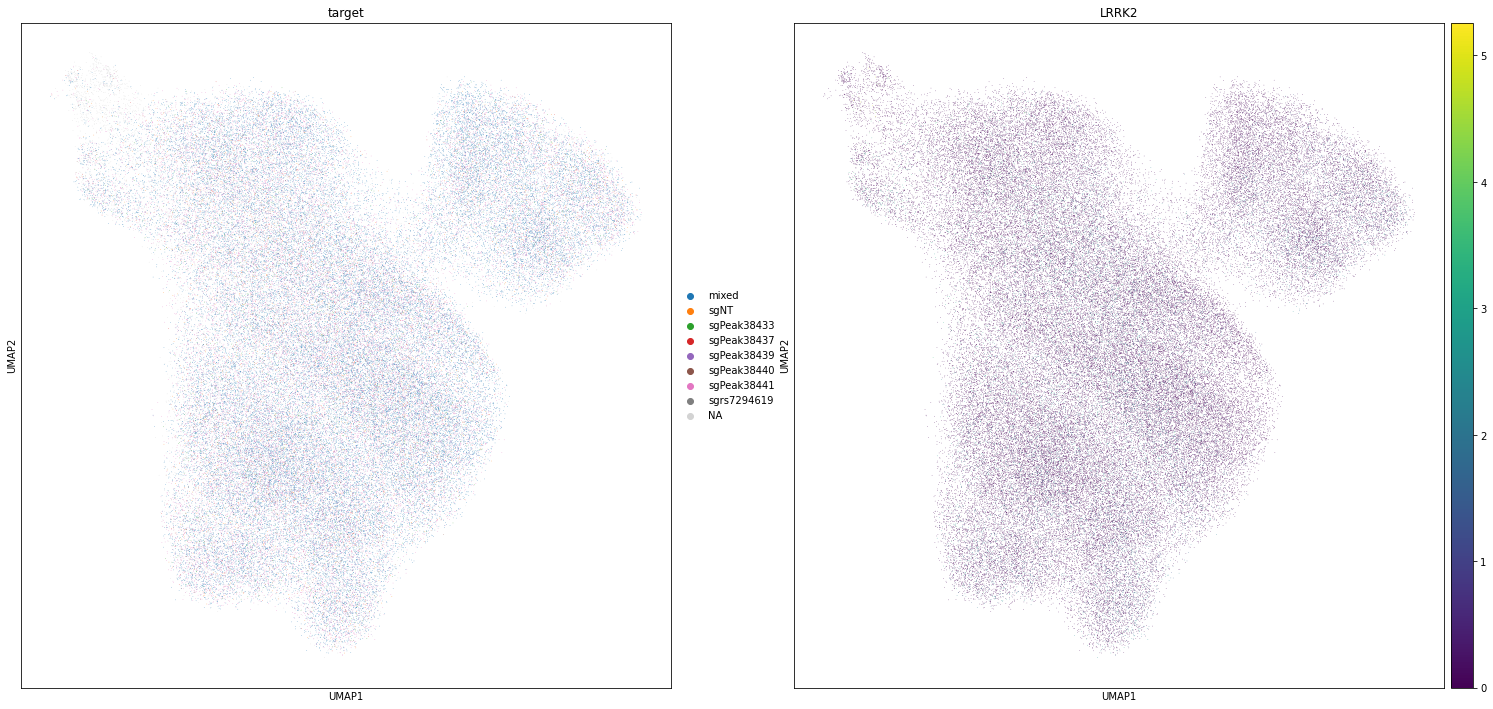

In [52]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(subdata, color=['target', 'LRRK2'], use_raw=False)

### Clustering the neighborhood graph
As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [53]:
sc.tl.leiden(subdata, resolution=0.5)

#### Plot the clusters

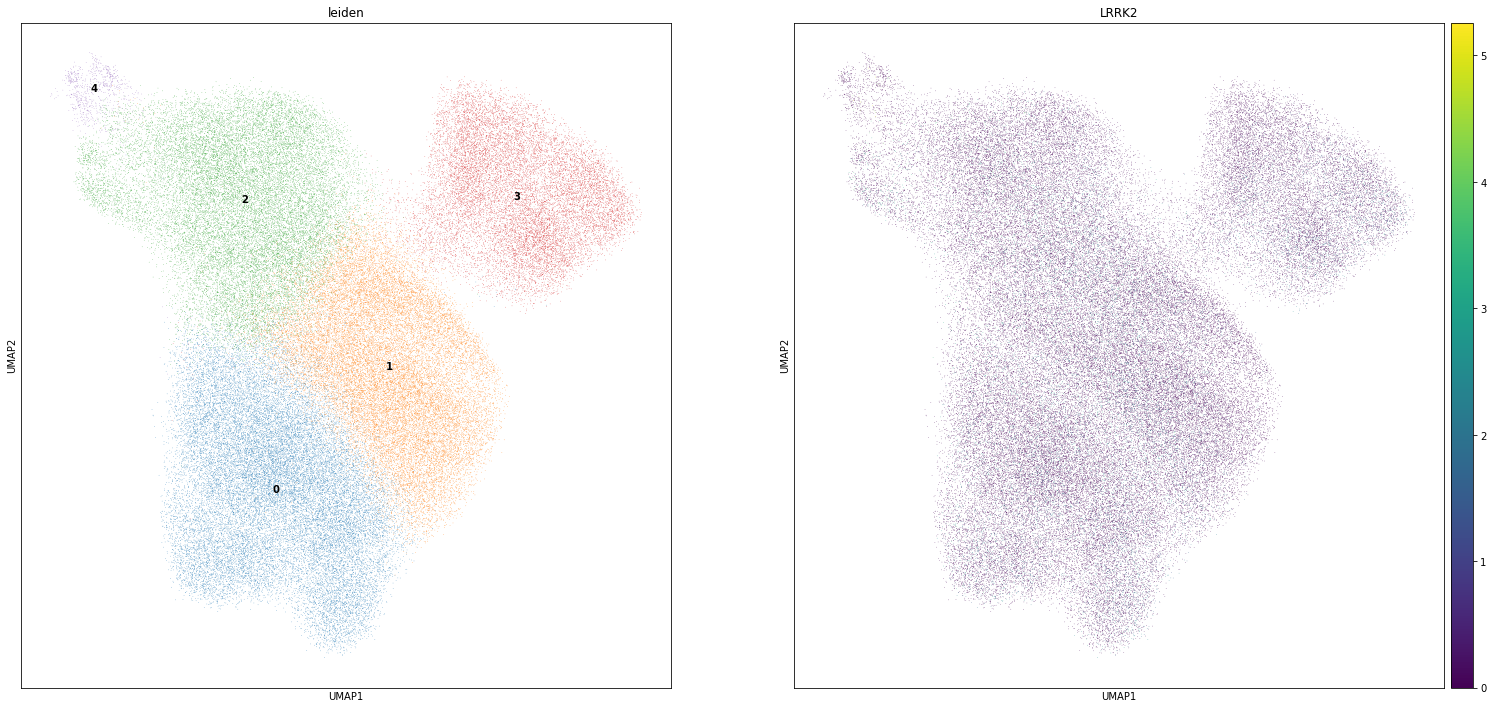

In [54]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(subdata, color=['leiden', 'LRRK2'], legend_loc='on data')

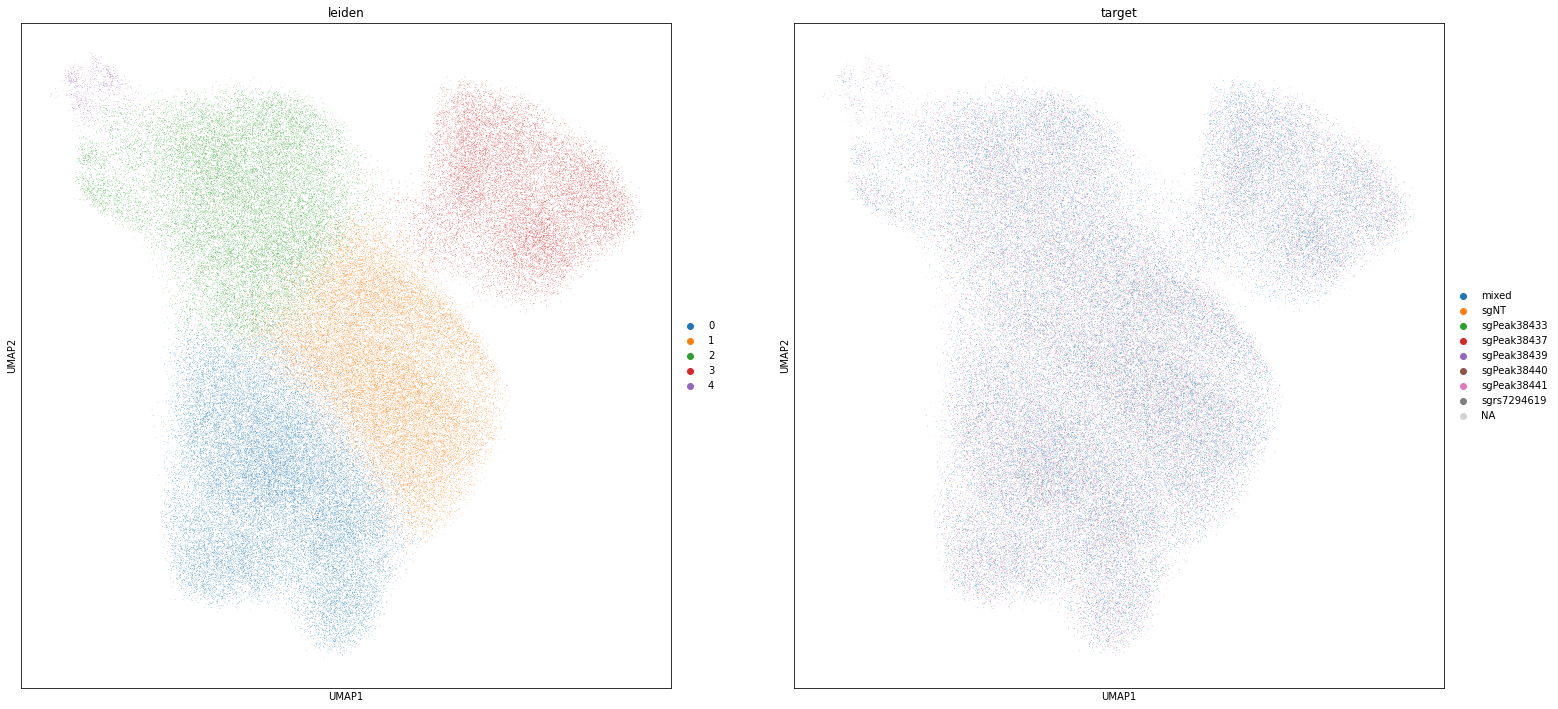

In [55]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(subdata, color=['leiden', 'target'])

### Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.



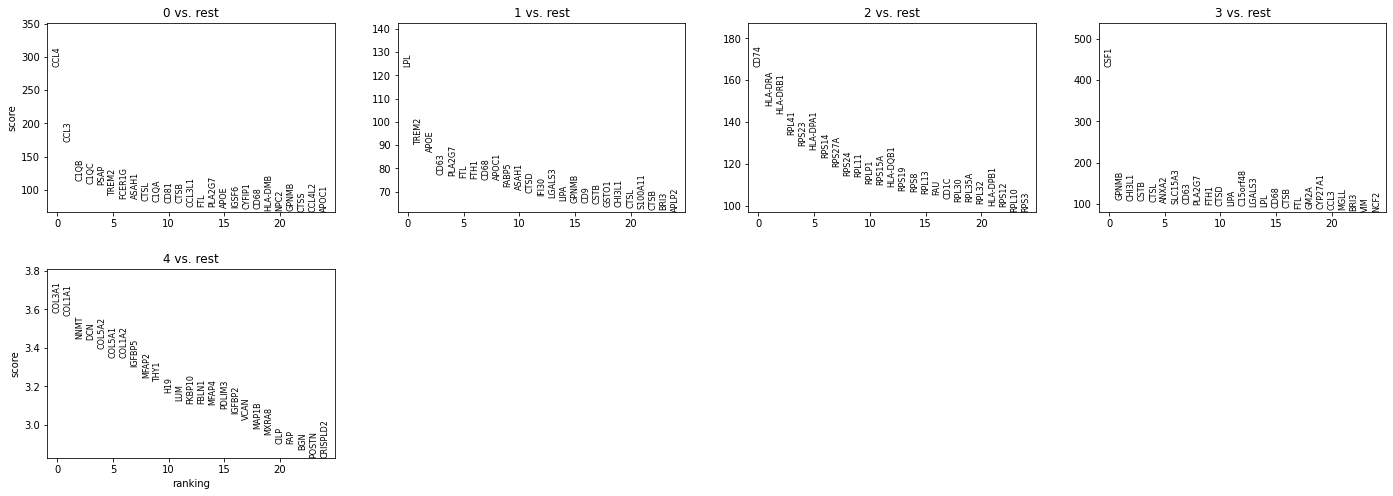

In [56]:
sc.tl.rank_genes_groups(subdata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(subdata, n_genes=25, sharey=False)

#### The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

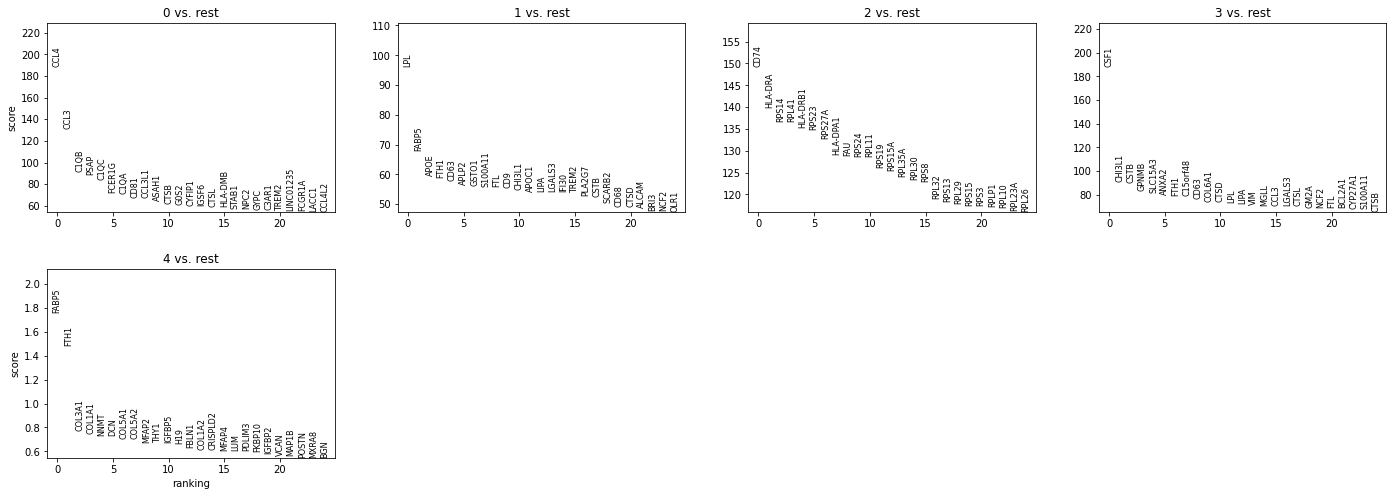

In [57]:
sc.tl.rank_genes_groups(subdata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(subdata, n_genes=25, sharey=False)

#### Now that we annotated the cell types, let us visualize the genes of interest.

In [58]:
subdata

AnnData object with n_obs × n_vars = 93748 × 42
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'target_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

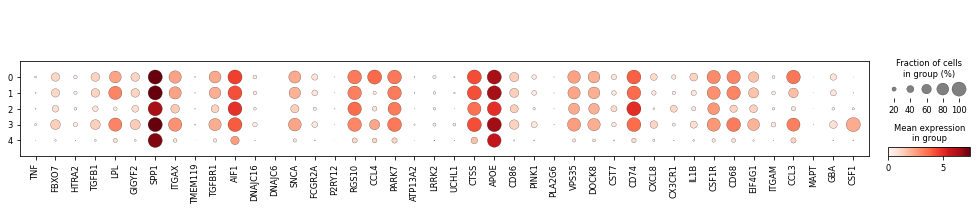

In [59]:
sc.pl.dotplot(subdata, genes_oi_in_data, groupby='leiden')

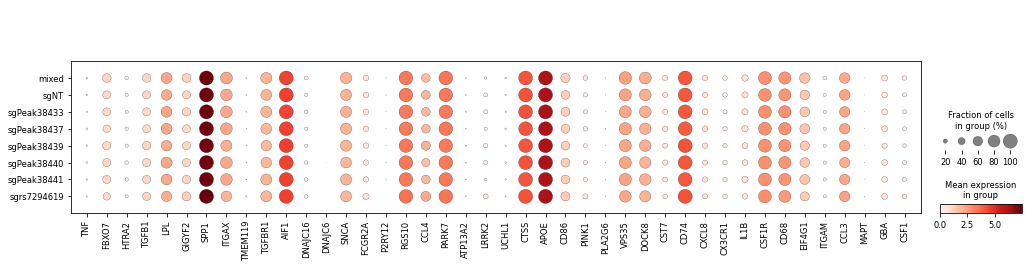

In [60]:
sc.pl.dotplot(subdata, genes_oi_in_data, groupby='target')

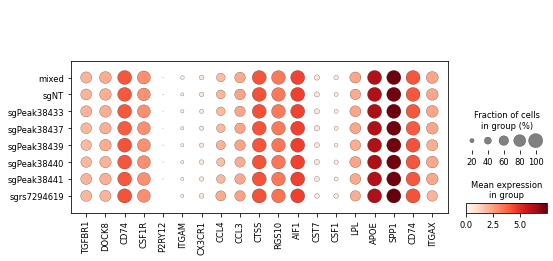

In [61]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.dotplot(subdata, cell_markers, groupby='target')

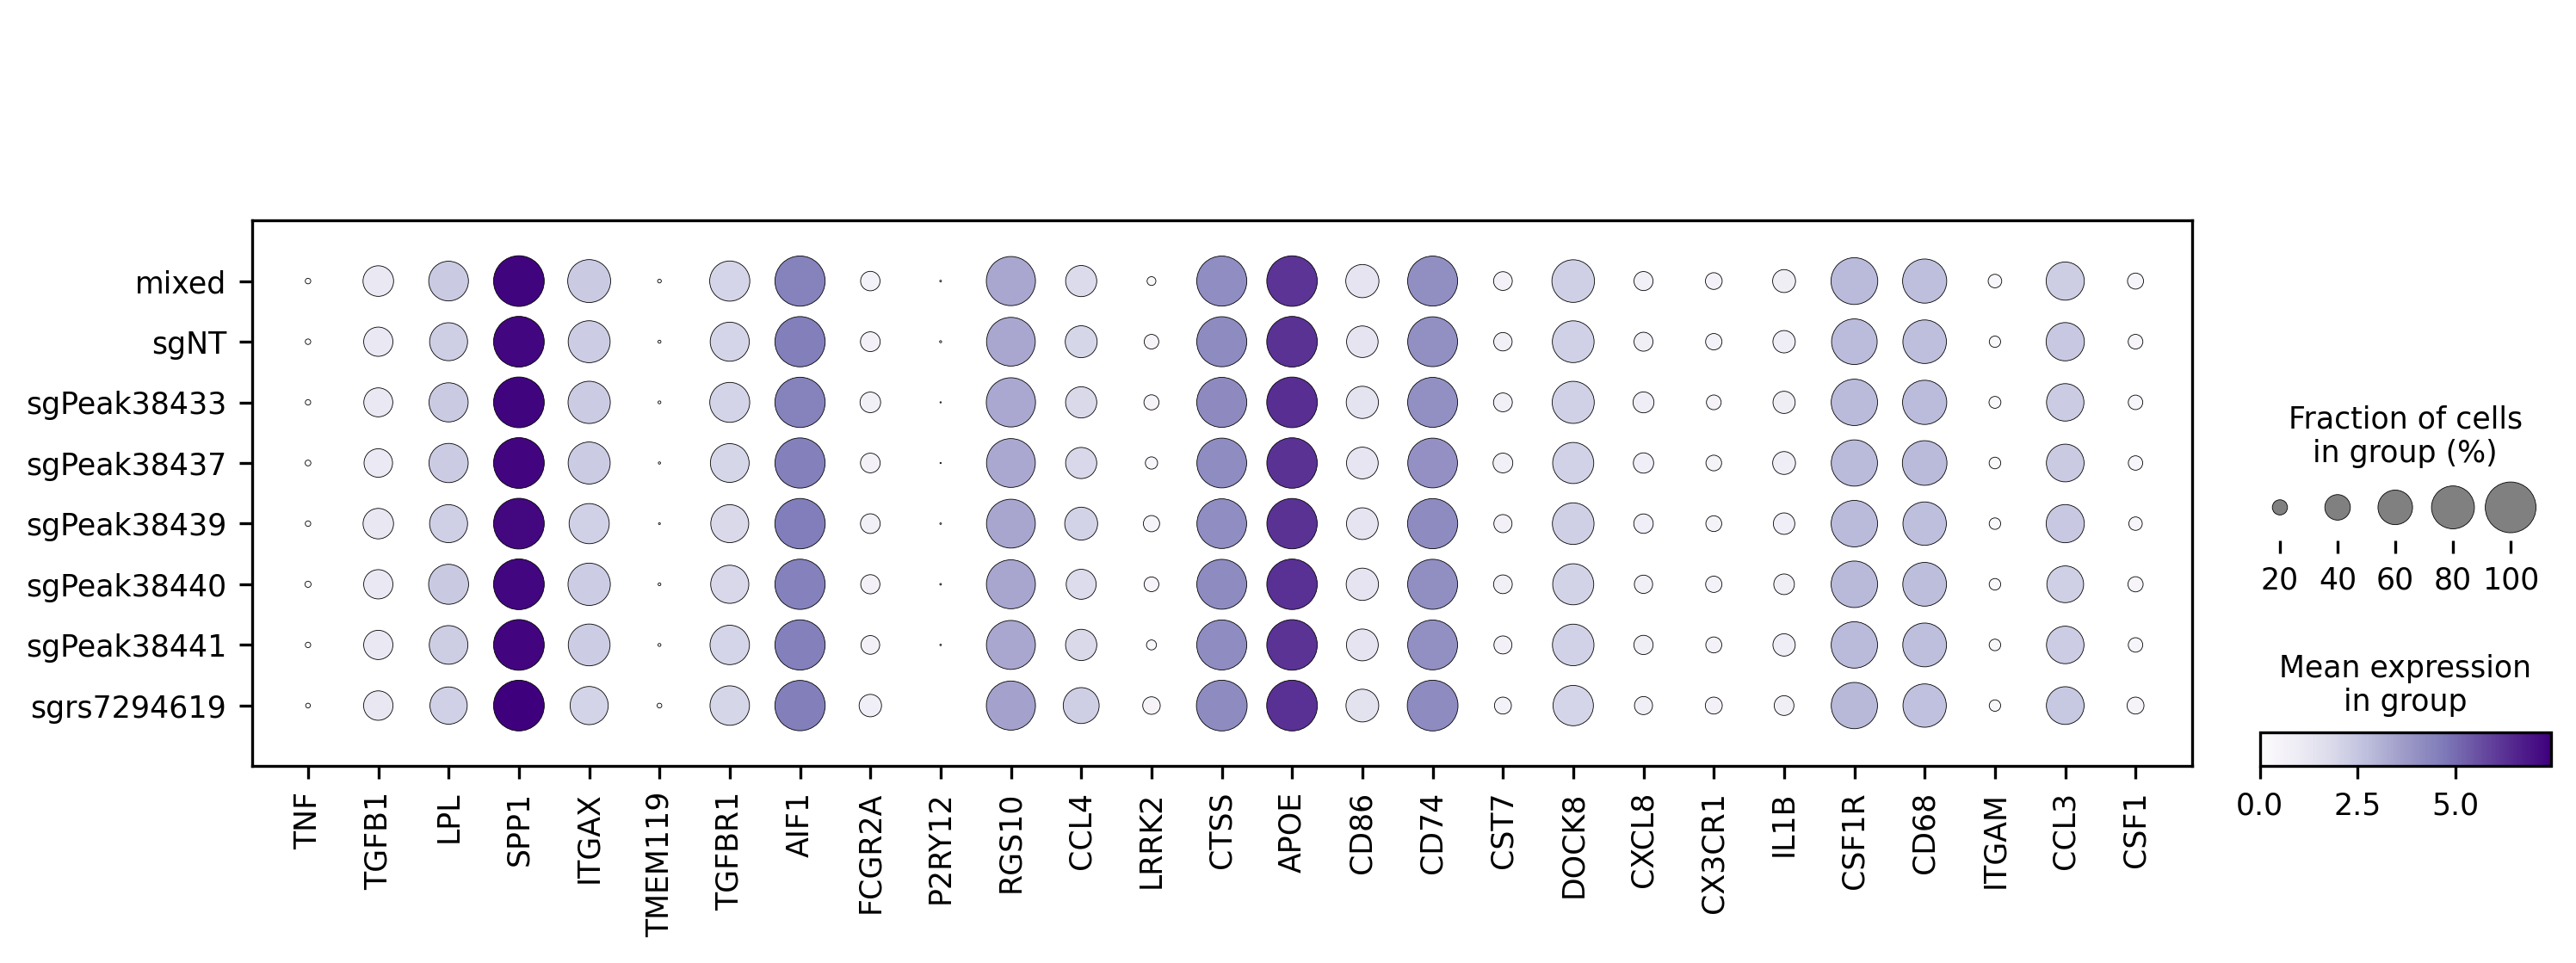

In [62]:
these_cols = [gene_oi, f'adj_{gene_oi}'] + cell_markers + fig_s5_markers
these_cols = list(set(these_cols) & set(subdata.var.index))
with rc_context({'figure.figsize': (12, 12), 'figure.dpi': 300}):
    plt.style.use('seaborn-bright')
    sc.pl.dotplot(subdata, these_cols, groupby='target', cmap='Purples')

#### format and export dotplot for potential use a supplmental figure

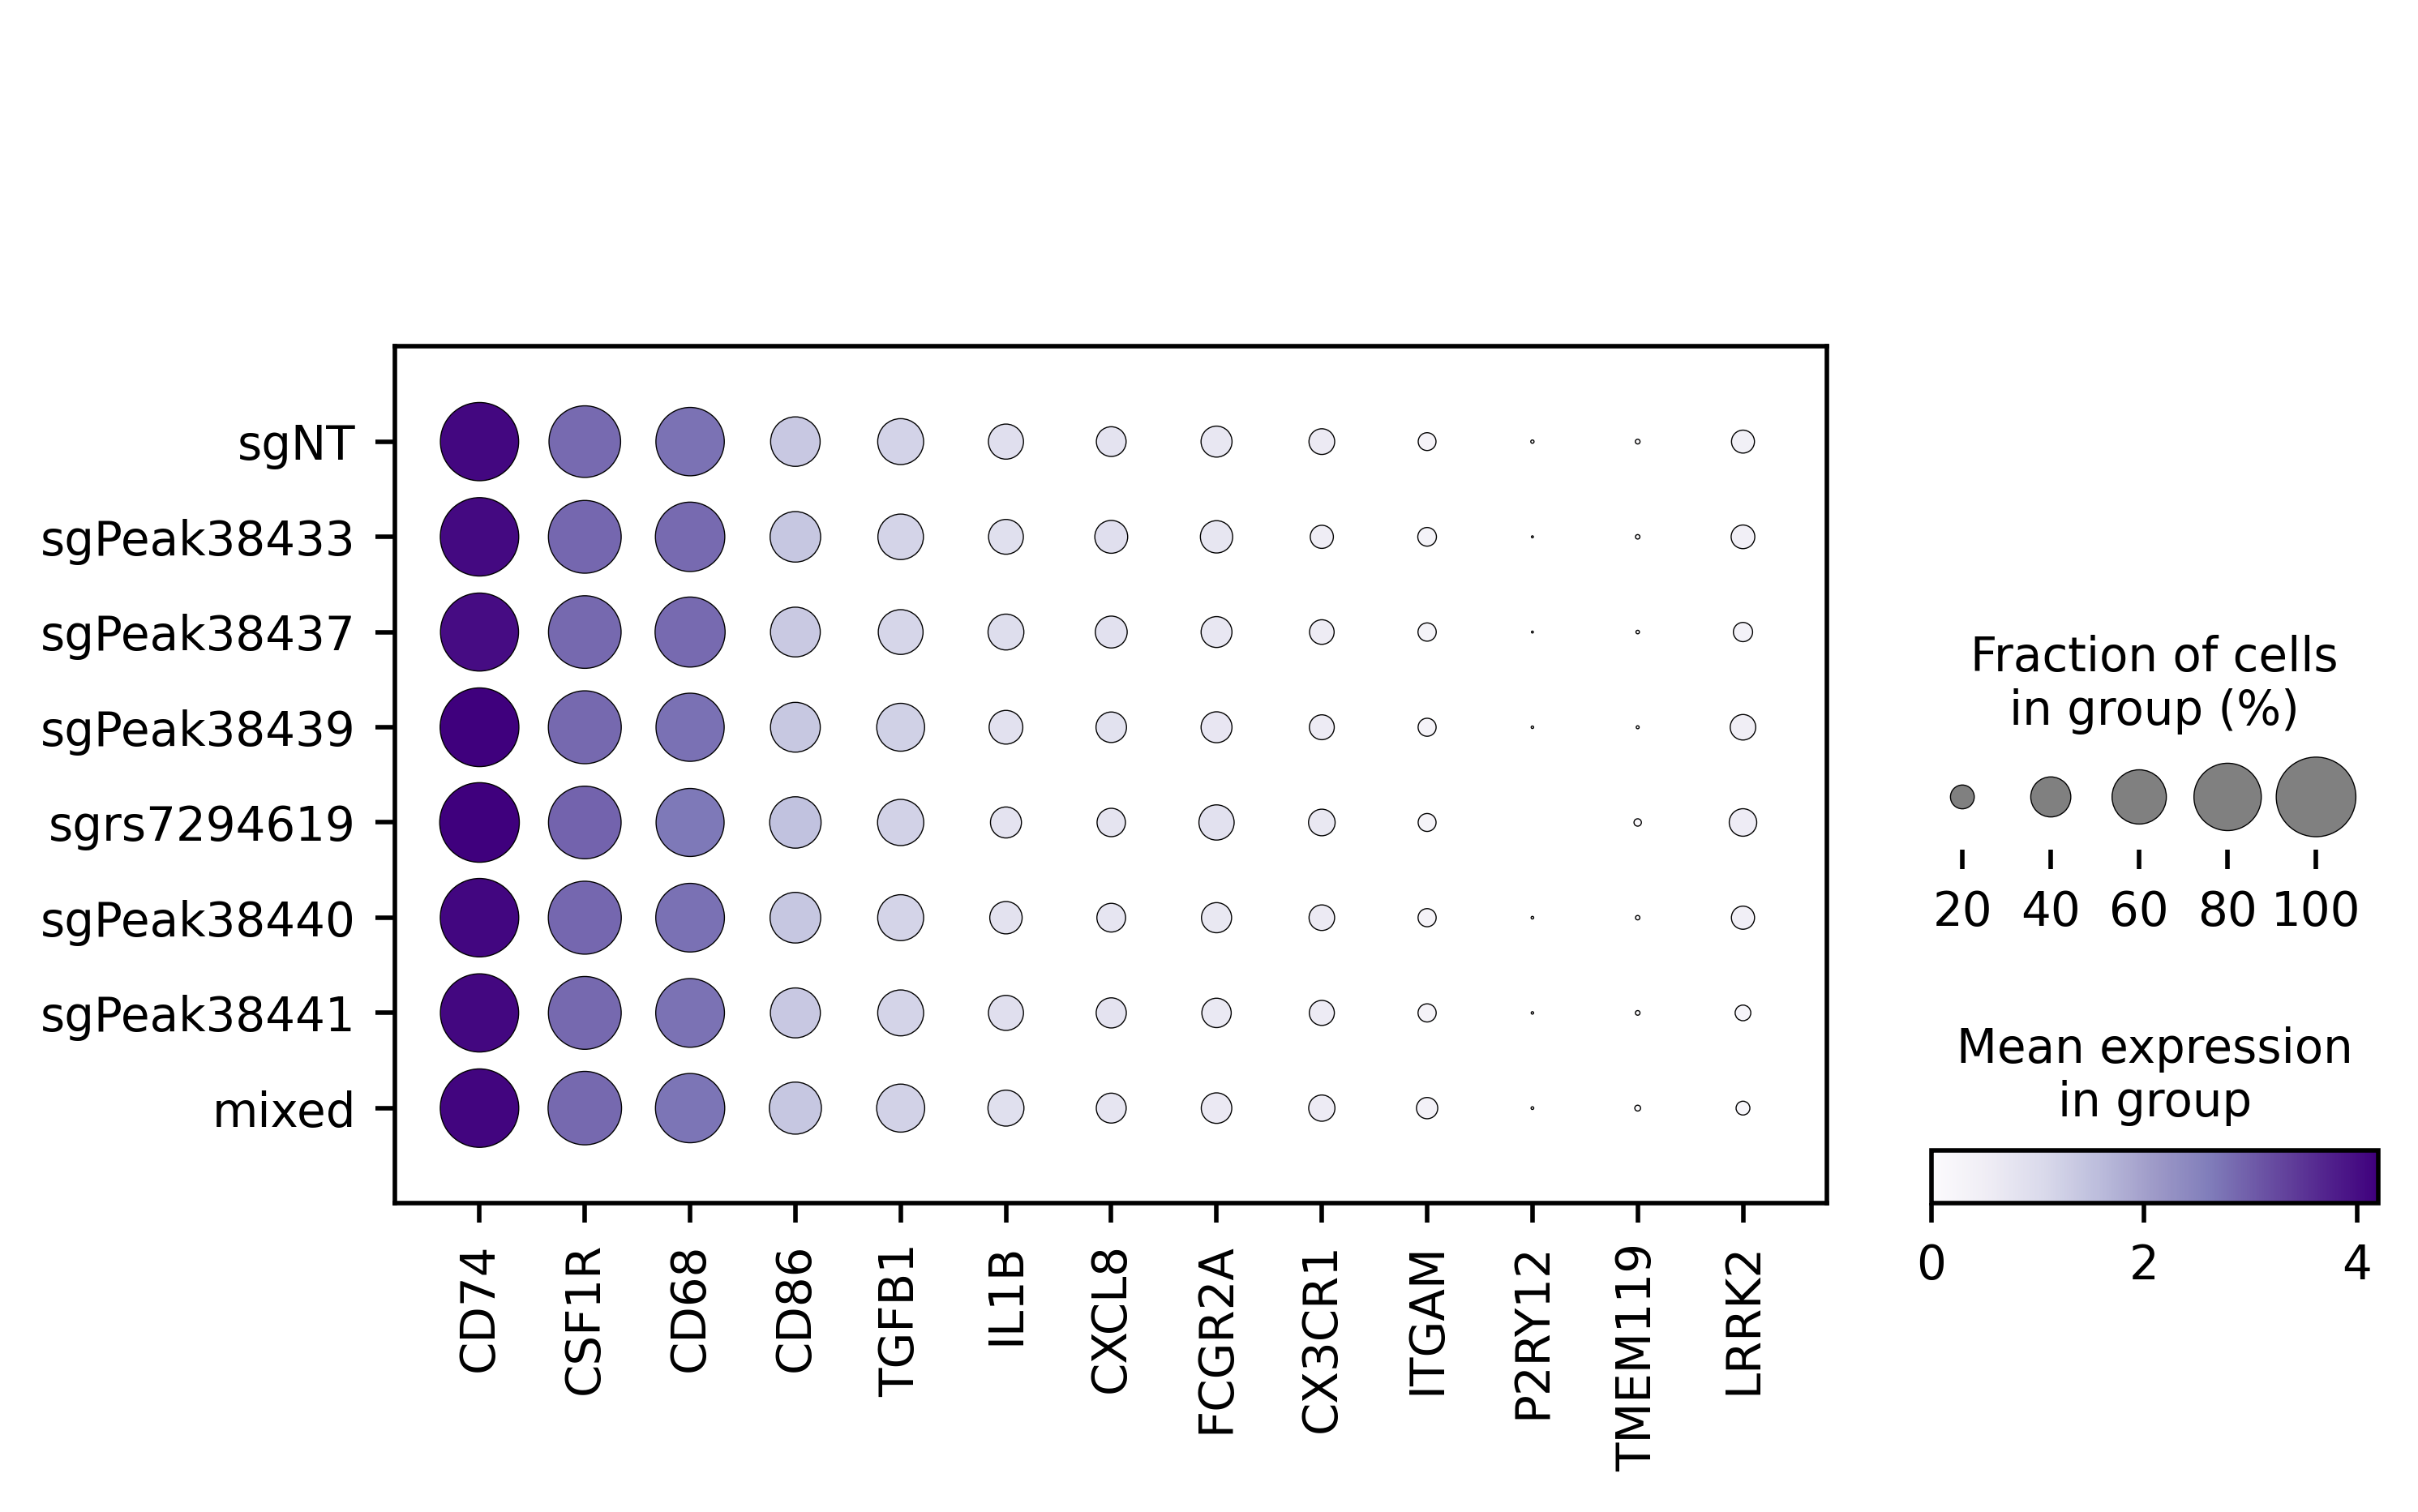

In [63]:
these_cols = ["CD74", "CSF1R", "CD68", "CD86", "TGFB1", "IL1B", 
              "CXCL8", "FCGR2A", "CX3CR1", "ITGAM", "P2RY12", "TMEM119", "LRRK2"]
# these_cols = list(set(these_cols) & set(subdata.var.index))
with rc_context({'figure.figsize': (8, 8), 'figure.dpi': 500}):
    plt.style.use('seaborn-bright')
#     sc.pl.dotplot(subdata, these_cols, groupby='target', 
#                   categories_order=ordered_targets, 
#                   cmap='Purples')
    sc.pl.DotPlot(subdata, these_cols, groupby='target', 
                  categories_order=ordered_targets, 
                  cmap='Purples').savefig(filename=f'{wrk_dir}/{cohort}.target.dotplot.svg', 
                                          format='svg') 

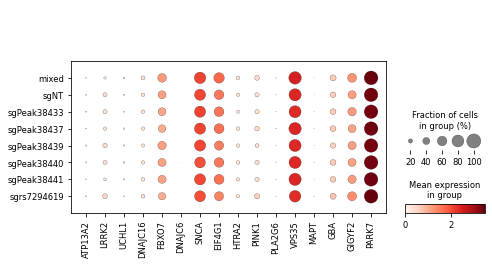

In [64]:
sc.pl.dotplot(subdata, list(set(dx_genes) & set(genes_oi_in_data)), groupby='target')

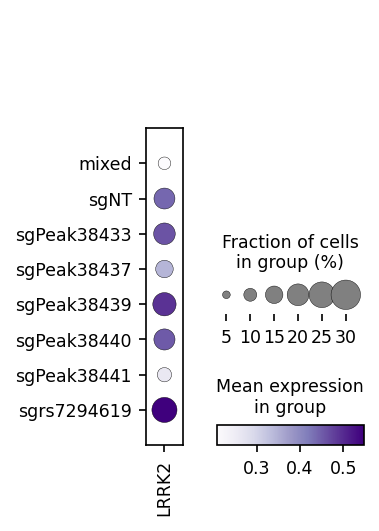

In [65]:
with rc_context({'figure.figsize': (8, 8), 'figure.dpi': 150}):
    plt.style.use('seaborn-bright')
    sc.pl.dotplot(subdata, ['LRRK2'], groupby='target', cmap='Purples')

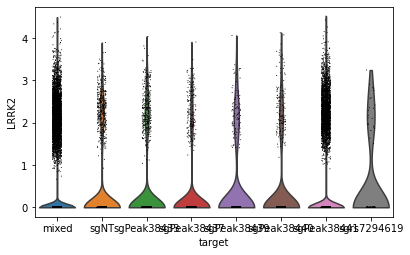

In [66]:
sc.pl.violin(subdata, ['LRRK2'], groupby='target')

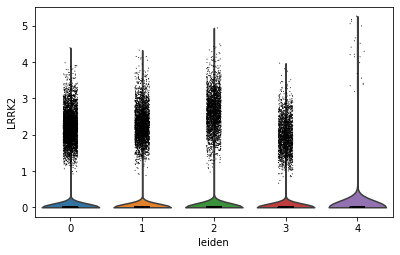

In [67]:
sc.pl.violin(subdata, ['LRRK2'], groupby='leiden')

In [68]:
subdata

AnnData object with n_obs × n_vars = 93748 × 42
    obs: 'expr_name', 'num_features', 'feature_call', 'num_umis', 'target', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'target_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [69]:
print(subdata.obs['target'].value_counts())

mixed          44517
sgPeak38441    25864
sgNT            2122
sgPeak38433     1634
sgPeak38437     1284
sgPeak38440      764
sgPeak38439      406
sgrs7294619       95
Name: target, dtype: int64


In [70]:
print(subdata.obs['leiden'].value_counts())

0    28921
1    26185
2    22535
3    15313
4      794
Name: leiden, dtype: int64


#### save the modified anndata object

In [71]:
subdata.write(results_file)

In [72]:
!date

Fri Feb 18 16:04:17 EST 2022
